# Motivation
This notebook is used for exploring useful features and generate corresponding datasets for later modeling.

# Imports and utils

In [1]:
import numpy as np
import pandas as pd
import os
import time
import datetime
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn import metrics
import lightgbm as lgb
#import openbabel as ob
from scipy import stats
from random import random

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: #and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

def encode_categoric(df):
    lbl = LabelEncoder()
    cat_cols=[]
    try:
        cat_cols = df.describe(include=['O']).columns.tolist()
        for cat in cat_cols:
            df[cat] = lbl.fit_transform(list(df[cat].values))
    except Exception as e:
        print('error: ', str(e) )

    return df

In [21]:
def getDuplicateColumns(df):
    duplicateColumnNames = set()
    #goodCol = set()
    
    for x in range(df.shape[1]):
        col = df.iloc[:, x]
        for y in range(x + 1, df.shape[1]):
            otherCol = df.iloc[:, y]
            if col.equals(otherCol):
                #goodCol.add(df.colu)
                duplicateColumnNames.add(df.columns.values[y])
    
    return list(duplicateColumnNames)

## Load data

In [4]:
structures = pd.read_csv('C:/Users/tyhe1/kaggle/Molecular_properties/champs-scalar-coupling/structures.csv')

In [5]:
train = pd.read_csv('C:/Users/tyhe1/kaggle/Molecular_properties/test_start.csv')

In [ ]:
dipole = pd.read_csv('C:/Users/tyhe1/kaggle/Molecular_properties/champs-scalar-coupling/dipole_moments.csv')

In [ ]:
structures.head()

In [ ]:
magnetic_shielding = pd.read_csv('C:/Users/tyhe1/kaggle/Molecular_properties/champs-scalar-coupling/magnetic_shielding_tensors.csv')

In [ ]:
magnetic_shielding.head()

In [ ]:
QM9 = pd.read_csv('C:/Users/tyhe1/kaggle/Molecular_properties/QM9_processed.csv')

In [6]:
structures_mulliken = pd.read_csv('C:/Users/tyhe1/kaggle/Molecular_properties/QM9_mulliken_processed.csv')

In [ ]:
structures_mulliken.head()

In [ ]:
cols_todrop = QM9.columns[6:-2]

In [ ]:
QM9.drop(cols_todrop, axis = 1, inplace = True)
QM9.drop(['id', 'scalar_coupling_constant','type'], axis = 1, inplace = True)

In [ ]:
train = pd.merge(train, QM9, how = 'left', left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1'],
                  right_on = ['molecule_name',  'atom_index_0', 'atom_index_1'])

In [ ]:
test = pd.merge(test, QM9, how = 'left', left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1'],
                  right_on = ['molecule_name',  'atom_index_0', 'atom_index_1'])

In [6]:
train.head()

,Unnamed: 0,molecule_name,atom_index_0,atom_index_1,type,EN_0,rad_0,EN_1,rad_1,n_bonds_1,...,cos_closest_0,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_min_diff,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_min_div,yukawa,mole_atom_idx_0_inverse_dist_3_sum,mole_atom_idx_0_inverse_dist_3_mean,inverse_dist_En
0,0,dsgdb9nsd_000004,2,0,2JHC,2.2,0.43,2.55,0.82,2,...,1.0,3.323277,1.062099,-1.199079,0.000000,0.46971,-0.001975,1.054416,3.163247,0.078404
1,1,dsgdb9nsd_000004,2,1,1JHC,2.2,0.43,2.55,0.82,2,...,-1.0,3.323277,2.261178,0.000000,1.199079,1.00000,-0.013948,1.054416,3.163247,0.166920
2,2,dsgdb9nsd_000004,2,3,3JHH,2.2,0.43,2.20,0.43,1,...,1.0,3.323277,0.000000,-2.261178,0.000000,1.00000,0.000465,1.054416,3.163247,0.062171
3,3,dsgdb9nsd_000004,3,0,1JHC,2.2,0.43,2.55,0.82,2,...,-1.0,2.261178,1.199079,0.000000,1.199079,1.00000,-0.013948,1.085603,2.171206,0.166920
4,4,dsgdb9nsd_000004,3,1,2JHC,2.2,0.43,2.55,0.82,2,...,1.0,2.261178,0.000000,-1.199079,0.000000,0.46971,-0.001975,1.085603,2.171206,0.078404


All these feture generation functions based on public kernels:
 - https://www.kaggle.com/artgor/using-meta-features-to-improve-model
 - https://www.kaggle.com/aekoch95/bonds-from-structure-data
 - https://www.kaggle.com/adrianoavelar/bond-calculation-lb-0-82
 - https://www.kaggle.com/kmat2019/effective-feature
 
**Please upvote them!**

# Create features based on structures.csv

In [7]:
def atomic_radius_electonegativety(structures):
    atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor
    fudge_factor = 0.05
    atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}

    electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

    atoms = structures['atom'].values
    atoms_en = [electronegativity[x] for x in atoms]
    atoms_rad = [atomic_radius[x] for x in atoms]

    structures['EN'] = atoms_en
    structures['rad'] = atoms_rad
    
    return structures


def create_bonds(structures):
    i_atom = structures['atom_index'].values
    p = structures[['x', 'y', 'z']].values
    p_compare = p
    m = structures['molecule_name'].values
    m_compare = m
    r = structures['rad'].values
    r_compare = r

    source_row = np.arange(len(structures))
    max_atoms = 28

    bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
    bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

    for i in range(max_atoms-1):
        p_compare = np.roll(p_compare, -1, axis=0)
        m_compare = np.roll(m_compare, -1, axis=0)
        r_compare = np.roll(r_compare, -1, axis=0)

        mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
        dists = np.linalg.norm(p - p_compare, axis=1) * mask
        r_bond = r + r_compare

        bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)

        source_row = source_row
        target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
        target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row

        source_atom = i_atom
        target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
        target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col

        bonds[(source_row, target_atom)] = bond
        bonds[(target_row, source_atom)] = bond
        bond_dists[(source_row, target_atom)] = dists
        bond_dists[(target_row, source_atom)] = dists

    bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
    bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
    bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
    bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

    bonds_numeric = [[i for i,x in enumerate(row) if x] for row in bonds]
    bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(bond_dists)]
    bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
    n_bonds = [len(x) for x in bonds_numeric]

    bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
    bond_df = pd.DataFrame(bond_data)
    structures = structures.join(bond_df)
    
    return structures

def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}',
                            'EN': f'EN_{atom_idx}',
                            'rad': f'rad_{atom_idx}',
                            'n_bonds': f'n_bonds_{atom_idx}',
                            'bond_lengths_mean': f'bond_lengths_mean_{atom_idx}',
                           })
    return df

In [8]:
structures = atomic_radius_electonegativety(structures)
structures = create_bonds(structures)

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)
train.columns

In [ ]:
train.tail()

## More feature engineering

In [ ]:
def distances(df):
    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values
    
    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    
    df['type_0'] = df['type'].apply(lambda x: x[0])
    
    return df

def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance', 'dist'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})
    df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'], inplace = True)
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
    return df

def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df['distance_closest_0_1'] = ((df['x_closest_0']-df['x_closest_1'])**2+(df['y_closest_0']-df['y_closest_1'])**2+(df['z_closest_0']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_closest_x"]=(df['x_closest_0']-df['x_closest_1'])/df["distance_closest_0_1"]
    df["vec_closest_y"]=(df['y_closest_0']-df['y_closest_1'])/df["distance_closest_0_1"]
    df["vec_closest_z"]=(df['z_closest_0']-df['z_closest_1'])/df["distance_closest_0_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df['cos_closest_0'] = df["vec_0_x"]*df["vec_closest_x"]+df["vec_0_y"]*df["vec_closest_y"]+df["vec_0_z"]*df["vec_closest_z"]
    df['cos_closest_1'] = df["vec_1_x"]*df["vec_closest_x"]+df["vec_1_y"]*df["vec_closest_y"]+df["vec_1_z"]*df["vec_closest_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z',
               'vec_closest_x', 'vec_closest_y', 'vec_closest_z'], axis=1)
    return df

def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    
    return df

In [ ]:
def Coulomb(dist, mulliken_0, mulliken_1):
    y = mulliken_0 * mulliken_1 / dist
    return y

def Coulomb_Cutoff(dist, mulliken_0, mulliken_1, Rc):
    if dist <= Rc:
        y = mulliken_0 * mulliken_1 / dist
    else:
        y = 0
    return y

In [ ]:
train.head()

In [ ]:
start_time = time.time()

train = distances(train)

In [ ]:
print('Create closest features')

train = create_closest(train)

In [ ]:
print('Create cos features')

train = add_cos_features(train)

In [ ]:
print('Create groupby features', end='\n\n')

train = create_features(train)

In [ ]:
train.head()

In [ ]:
y_tr = train.pop('scalar_coupling_constant')

In [ ]:
test.shape

In [ ]:
cols_tokeep = [ col for col in train.columns.values if col not in [ 'atom_0', 'atom_1',
                     'type_0', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'scalar_coupling_constant', 'x_0_closest', 'y_0_closest', 
                     'z_0_closest', 'x_1_closest', 'y_1_closest', 'z_1_closest', 'type_x', 'type_y', 'scalar_coupling_constant_x',
                    #'EN_0', #'rad_0',
                    'x_atom_index_1_closest', 'y_atom_index_1_closest', 'z_atom_index_1_closest', 'moelcule_name', 'scalar_coupling_constant_y',
                   'x_closest_0', 'y_closest_0', 'z_closest_0', 'x_atom_index_1', 'y_atom_index_1', 'z_atom_index_1',
                   'x_closest_1', 'y_closest_1', 'z_closest_1', 'x_atom_index_0', 'y_atom_index_0', 'z_atom_index_0',
                   'molecule_atom_index_0_dist_min', 'n_bonds_0', 'molecule_name', 'magnitude_0', 'magnitude_1', 'multiply_magnitude',
                    'oof', 'target', 'O_bond_lengths_mean_sum', 'C_bond_lengths_mean_sum', 'total_atom_number',
                     'XY_0', 'YX_0', 'XZ_0', 'ZX_0', 'YZ_0', 'ZY_0', 'XY_1', 'YX_1', 'XZ_1', 'ZX_1', 'ZY_1', 'YZ_1',
                   'XX_0', 'YY_0', 'ZZ_0', 'XX_1', 'YY_1', 'ZZ_1', 'multiply_XX', 'multiply_YY', 'multiply_ZZ',
'x_atom_index_0_closest', 'y_atom_index_0_closest', 'z_atom_index_0_closest', 'dist_x', 'dist_y', 'dist_z','id'] ]

In [ ]:
train = train[cols_tokeep]
test = test[cols_tokeep]

In [ ]:
train['multiply_mulliken'] = train['mulliken_atom_0'] * train['mulliken_atom_1']
train['Coulomb'] = train['multiply_mulliken'] / train['dist']

In [ ]:
test['multiply_mulliken'] = test['mulliken_atom_0'] * test['mulliken_atom_1']
test['Coulomb'] = test['mulliken_atom_0'] * test['mulliken_atom_1'] / test['dist']

In [ ]:
train['yukawa'] = train['Coulomb'] * np.exp(-train['dist'])

In [ ]:
train['inverse_dist_3'] = 1 / (train['dist'] * train['dist'] * train['dist'])

In [ ]:
train[f'mole_atom_idx_0_inverse_dist_3_sum'] = 1/(train.groupby(['molecule_name', 'atom_index_0'])['inverse_dist_3'].transform('sum'))
train[f'mole_atom_idx_1_inverse_dist_3_sum'] = 1/(train.groupby(['molecule_name', 'atom_index_1'])['inverse_dist_3'].transform('sum'))
train['combine_inverse_dist'] = (train[f'mole_atom_idx_0_inverse_dist_3_sum'] * train[f'mole_atom_idx_1_inverse_dist_3_sum'])/ ((train[f'mole_atom_idx_0_inverse_dist_3_sum'] + train[f'mole_atom_idx_1_inverse_dist_3_sum']))

In [ ]:
train[f'mole_atom_idx_0_inverse_dist_3_mean'] = 1/(train.groupby(['molecule_name', 'atom_index_0'])['inverse_dist_3'].transform('mean'))
train[f'mole_atom_idx_1_inverse_dist_3_mean'] = 1/(train.groupby(['molecule_name', 'atom_index_1'])['inverse_dist_3'].transform('mean'))
train['combine_inverse_dist_mean'] = (train[f'mole_atom_idx_0_inverse_dist_3_mean'] * train[f'mole_atom_idx_1_inverse_dist_3_mean'])/ ((train[f'mole_atom_idx_0_inverse_dist_3_mean'] + train[f'mole_atom_idx_1_inverse_dist_3_mean']))

In [ ]:
train[f'mole_atom_idx_0_inverse_dist_3_std'] = 1/(train.groupby(['molecule_name', 'atom_index_0'])['inverse_dist_3'].transform('std'))
train[f'mole_atom_idx_1_inverse_dist_3_std'] = 1/(train.groupby(['molecule_name', 'atom_index_1'])['inverse_dist_3'].transform('std'))
train['combine_inverse_dist_std'] = (train[f'mole_atom_idx_0_inverse_dist_3_std'] * train[f'mole_atom_idx_1_inverse_dist_3_std'])/ ((train[f'mole_atom_idx_0_inverse_dist_3_std'] + train[f'mole_atom_idx_1_inverse_dist_3_std']))

In [ ]:
train['inverse_rad_dist_diff'] = 1 / ((train['dist'] - train['rad_0'] - train['rad_1']) ** 2)

In [ ]:
train[f'mole_atom_idx_0_inverse_rad_dist_diff_sum'] = 1/(train.groupby(['molecule_name', 'atom_index_0'])['inverse_rad_dist_diff'].transform('sum'))
train[f'mole_atom_idx_1_inverse_rad_dist_diff_sum'] = 1/(train.groupby(['molecule_name', 'atom_index_1'])['inverse_rad_dist_diff'].transform('sum'))
train['combine_inverse_rad_dist_diff'] = (train[f'mole_atom_idx_0_inverse_rad_dist_diff_sum'] * train[f'mole_atom_idx_1_inverse_rad_dist_diff_sum'])/ ((train[f'mole_atom_idx_0_inverse_rad_dist_diff_sum'] + train[f'mole_atom_idx_1_inverse_rad_dist_diff_sum']))

In [ ]:
train[f'mole_atom_idx_0_inverse_rad_dist_diff_mean'] = 1/(train.groupby(['molecule_name', 'atom_index_0'])['inverse_rad_dist_diff'].transform('mean'))
train[f'mole_atom_idx_1_inverse_rad_dist_diff_mean'] = 1/(train.groupby(['molecule_name', 'atom_index_1'])['inverse_rad_dist_diff'].transform('mean'))
train['combine_inverse_rad_dist_diff_mean'] = (train[f'mole_atom_idx_0_inverse_rad_dist_diff_mean'] * train[f'mole_atom_idx_1_inverse_rad_dist_diff_mean'])/ ((train[f'mole_atom_idx_0_inverse_rad_dist_diff_mean'] + train[f'mole_atom_idx_1_inverse_rad_dist_diff_mean']))

In [ ]:
train[f'mole_atom_idx_0_inverse_rad_dist_diff_std'] = 1/(train.groupby(['molecule_name', 'atom_index_0'])['inverse_rad_dist_diff'].transform('std'))
train[f'mole_atom_idx_1_inverse_rad_dist_diff_std'] = 1/(train.groupby(['molecule_name', 'atom_index_1'])['inverse_rad_dist_diff'].transform('std'))
train['combine_inverse_rad_dist_diff_std'] = (train[f'mole_atom_idx_0_inverse_rad_dist_diff_std'] * train[f'mole_atom_idx_1_inverse_rad_dist_diff_std'])/ ((train[f'mole_atom_idx_0_inverse_rad_dist_diff_std'] + train[f'mole_atom_idx_1_inverse_rad_dist_diff_std']))

In [ ]:
train['inverse_dist_En'] = 1 / (train['dist'] * (train['EN_0'] * 0.5 + train['EN_1'] * 0.5) ** 2)

In [ ]:
train[f'mole_idx_0_inverse_dist_En_sum'] = 1/(train.groupby(['molecule_name', 'atom_index_0'])['inverse_dist_En'].transform('sum'))
train[f'mole_idx_1_inverse_dist_En_sum'] = 1/(train.groupby(['molecule_name', 'atom_index_1'])['inverse_dist_En'].transform('sum'))
train['combine_inverse_dist_En'] = (train[f'mole_idx_0_inverse_dist_En_sum'] * train[f'mole_idx_1_inverse_dist_En_sum'])/ ((train[f'mole_idx_0_inverse_dist_En_sum'] + train[f'mole_idx_1_inverse_dist_En_sum']))

In [ ]:
train[f'mole_idx_0_inverse_dist_En_mean'] = 1/(train.groupby(['molecule_name', 'atom_index_0'])['inverse_dist_En'].transform('mean'))
train[f'mole_idx_1_inverse_dist_En_mean'] = 1/(train.groupby(['molecule_name', 'atom_index_1'])['inverse_dist_En'].transform('mean'))
train['combine_inverse_dist_En_mean'] = (train[f'mole_idx_0_inverse_dist_En_mean'] * train[f'mole_idx_1_inverse_dist_En_mean'])/ ((train[f'mole_idx_0_inverse_dist_En_mean'] + train[f'mole_idx_1_inverse_dist_En_mean']))

In [ ]:
train[f'mole_idx_0_inverse_dist_En_std'] = 1/(train.groupby(['molecule_name', 'atom_index_0'])['inverse_dist_En'].transform('std'))
train[f'mole_idx_1_inverse_dist_En_std'] = 1/(train.groupby(['molecule_name', 'atom_index_1'])['inverse_dist_En'].transform('std'))
train['combine_inverse_dist_En_std'] = (train[f'mole_idx_0_inverse_dist_En_std'] * train[f'mole_idx_1_inverse_dist_En_std'])/ ((train[f'mole_idx_0_inverse_dist_En_std'] + train[f'mole_idx_1_inverse_dist_En_std']))

In [ ]:
for f in [#'type', 
          'atom_0_closest_x', 'atom_0_closest_y', 'atom_1_closest_x', 'atom_1_closest_y', 'atom_0', 'atom_1',
    'bond_0_0closest', 'bond_1_1closest', 'bond_0_1closest', 'bond_1_0closest', 'bond_1closest_0closest',
]:
lbl = LabelEncoder()
lbl.fit(list(train[f].values))
train[f] = lbl.transform(list(train[f].values))
#test[f] = lbl.transform(list(test[f].values))

In [ ]:
train.head()

In [ ]:
All_mole['molecule_name'] = molecules

In [ ]:
train['molecule_name'] = df_molecules['molecule_name']
train = pd.merge(train, All_mole[['molecule_name', 'C_bond_lengths_mean_sum',
                                 'O_bond_lengths_mean_sum', 'total_atom_number']], how = 'left', left_on = ['molecule_name'], right_on = ['molecule_name'])

In [ ]:
df_start_feature = pd.read_csv('C:/Users/tyhe1/kaggle/Molecular_properties/starting_feature.csv')

In [ ]:
good_feature = [col for col in train.columns.values if col in list(df_start_feature['feature'].values)]

In [ ]:
train = train[good_feature]

In [ ]:
train = reduce_mem_usage(train)

# General preparation

In [22]:
train.drop('Unnamed: 0', axis = 1, inplace = True)

In [23]:
train['type_0'] = train['type'].apply(lambda x: x[0])

In [24]:
train.rename(columns = {
            'EN_0': 'EN_atom_index_0',
            'EN_1': 'EN_atom_index_1',
            'rad_0': 'rad_atom_index_0',
            'rad_1': 'rad_atom_index_1',
}, inplace = True)

map_atom_info has shown up too many times in the notebook. Should try cleaning them up. This function is used to guarantee the atom index exits in the data so that we can locate different atoms in a molecule

In [25]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures_mulliken[['molecule_name', 'atom_index', 'mulliken', 'x', 'y', 'z', 
                                           #'EN', 'rad'
                                          ]], how = 'left',
                  left_on  = ['molecule_name', f'{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={
                            'mulliken': f'mulliken_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}',
                           })
    return df

In [26]:
train = map_atom_info(train, 'atom_index_0')
train = map_atom_info(train, 'atom_index_1')

In [189]:
structures.tail()

,molecule_name,atom_index,atom,x,y,z,EN,rad,n_bonds,bond_lengths_mean,mulliken
2358652,dsgdb9nsd_133885,11,H,-1.454004,-0.967309,1.459246,2.2,0.43,1,1.088204,0.078144
2358653,dsgdb9nsd_133885,12,H,0.277779,-2.697872,0.195770,2.2,0.43,1,1.080482,0.099332
2358654,dsgdb9nsd_133885,13,H,2.515854,-1.151784,0.527369,2.2,0.43,1,1.080551,0.114018
2358655,dsgdb9nsd_133885,14,H,0.013699,1.199431,-1.680192,2.2,0.43,1,1.088204,0.078144
2358656,dsgdb9nsd_133885,15,H,1.260745,-1.246754,-1.906767,2.2,0.43,1,1.080482,0.099331


# General Idea
According to the competition host, knowing the structure of a molecule is the key to guess its coupling constant. The number in different types of coupling ("1" in "1JHC", "2" in "2JHH") is the number of bonds between two atoms, which corresponds to different structures. And feature engineering can be based on these different structures. And from google I know the coupling constant is also determined by the connected atoms.

Above covers the gist of all the domain knowledge I picked up in this competition. Without knowing more professional ways to describe the structure of a molecule, my feature engineering focuses on answering basic questions when it comes to the structure of a molecule:
1. What is the type of an atom? And what atoms an atom is connected to?
2. Distance between atoms?
3. Angle of two bonds?
4. Type of the bond?

With the above four questions in mind, I did feature engineering for 1J, 2J and 3J. Then greedily select top 30 features and generate datasets for later modeling

### 1J 

In [67]:
train_testing_1J = train[train['type'] == '1JHC'].copy()

In [68]:
train_testing_1J = train_testing_1J.loc[:,~train_testing_1J.columns.duplicated()]

In [ ]:
features = set(list([feature for feature in train_testing.columns.values if feature in good_feature_general]) + list(['molecule_name', 'EN_0', 'EN_1', 
                               'atom_index_0', 'atom_index_1', 'rad_0', 'rad_1', 'x_atom_index_0', 'x_atom_index_1', 'y_atom_index_0', 'y_atom_index_1',
                 'scalar_coupling_constant', 'z_atom_index_0', 'z_atom_index_1', 'mulliken_atom_index_0', 'mulliken_atom_index_1']))

In [248]:
train_testing_1J = train_testing_1J[:25000]

In [ ]:
dict_feature = {'feature': list(features)}

In [ ]:
starting_feature = pd.DataFrame(dict_feature)

In [ ]:
starting_feature.to_csv('C:/Users/tyhe1/kaggle/Molecular_properties/starting_feature.csv')

In [ ]:
train_bonds.head()

In [ ]:
for f in [#'type', 
          #'atom_0_closest_x', 'atom_0_closest_y', 'atom_1_closest_x', 'atom_1_closest_y', 'atom_0', 'atom_1',
    'bond_0_0closest', 'bond_1_1closest', 'bond_0_1closest', 'bond_1_0closest', 'bond_1closest_0closest',
]:
    lbl = LabelEncoder()
    lbl.fit(list(train_testing_1J[f].values))
    train_testing_1J[f] = lbl.transform(list(train_testing_1J[f].values))

Get the properties of target_atom connected to atom at position source_atom_index

In [34]:
def aggregate_features_connected_atom(df, source_atom_index, target_atom):
    agg_func = {
            'L2dist': ['max', 'min', 'mean', 'count'],
            'nbond': ['max', 'min', 'mean'],
            'mulliken_1': ['max', 'min', 'mean'],
            'Coulomb': ['max', 'min', 'mean', 'sum'],
            'yukawa': ['max', 'min', 'mean', 'sum'],
            'inverse_dist_3': ['max', 'min', 'mean', 'sum'],
            'inverse_rad_dist_diff': ['max', 'min', 'mean', 'sum'],
            'inverse_dist_EN': ['max', 'min', 'mean', 'sum']
            }
    
    temp = train_bonds[train_bonds['atom_1'] == f'{target_atom}']

    grouped = temp.groupby(['molecule_name', 'ATOM_INDEX_0'])
    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)
    intermediate_group.columns = [f'{target_atom}_{source_atom_index}_' + col if col not in ['molecule_name', 'ATOM_INDEX_0'] else col for col in intermediate_group.columns.values]
    
    df = pd.merge(df, intermediate_group, how = 'left',
                           left_on = ['molecule_name', f'{source_atom_index}'],
                           right_on = ['molecule_name', 'ATOM_INDEX_0'])
    df.drop('ATOM_INDEX_0', axis = 1, inplace = True)
    
    values = {f'{target_atom}_{source_atom_index}_L2dist_count': 0.,
     }
    df.fillna(value = values, inplace = True)
    df.fillna(-1, inplace = True)
    
    del intermediate_group
    return df

In [71]:
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'atom_index_1', 'O')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'atom_index_1', 'N')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'atom_index_1', 'C')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'atom_index_1', 'H')

Get angle properties from three atoms: atom_index_start, atom_index_connect and atom_index_end, where atom_index_connect is in the middle connecting atom_index_start and atom_index_end.

In [38]:
def add_cos_features(df, atom_index_start, atom_index_connect, atom_index_end):
    
    df["distance_0"]=((df[f'x_{atom_index_start}']-df[f'x_{atom_index_connect}'])**2+(df[f'y_{atom_index_start}']-df[f'y_{atom_index_connect}'])**2+(df[f'z_{atom_index_start}']-df[f'z_{atom_index_connect}'])**2)**(0.5)
    df["distance_1"]=((df[f'x_{atom_index_end}']-df[f'x_{atom_index_connect}'])**2+(df[f'y_{atom_index_end}']-df[f'y_{atom_index_connect}'])**2+(df[f'z_{atom_index_end}']-df[f'z_{atom_index_connect}'])**2)**(0.5)
    
    df["vec_x_start"]=(df[f'x_{atom_index_start}']-df[f'x_{atom_index_connect}'])/df["distance_0"]
    df["vec_y_start"]=(df[f'y_{atom_index_start}']-df[f'y_{atom_index_connect}'])/df["distance_0"]
    df["vec_z_start"]=(df[f'z_{atom_index_start}']-df[f'z_{atom_index_connect}'])/df["distance_0"]
    df["vec_x_end"]=(df[f'x_{atom_index_end}']-df[f'x_{atom_index_connect}'])/df["distance_1"]
    df["vec_y_end"]=(df[f'y_{atom_index_end}']-df[f'y_{atom_index_connect}'])/df["distance_1"]
    df["vec_z_end"]=(df[f'z_{atom_index_end}']-df[f'z_{atom_index_connect}'])/df["distance_1"]
    
    df[f"cos_{atom_index_start}_{atom_index_connect}_{atom_index_end}"]=df["vec_x_start"]*df["vec_x_end"]+df["vec_y_start"]*df["vec_y_end"]+df["vec_z_start"]*df["vec_z_end"]
    
    df.loc[((df[f'x_{atom_index_connect}'] == 0.) & (df[f'y_{atom_index_connect}'] == 0.) & (df[f'z_{atom_index_connect}'] == 0.)) | ((df[f'x_{atom_index_end}'] == 0.) & (df[f'y_{atom_index_end}'] == 0.) & (df[f'z_{atom_index_end}'] == 0.)), f"cos_{atom_index_start}_{atom_index_connect}_{atom_index_end}"] = 360    
    
    df=df.drop(['vec_x_start','vec_y_start','vec_z_start','vec_x_end','vec_y_end','vec_z_end', 'distance_0', 'distance_1'
               ], axis=1)
    return df

Get angle and distance properties of a specific 'atom' connected to source_atom_index which is also connected to start_atom_index

In [39]:
def angle_dist_property_atom(df, atom, source_atom_index, start_atom_index):
    temp = train_bonds[train_bonds['atom_1'] == f'{atom}'].groupby(['molecule_name', 'ATOM_INDEX_0']).nth(0)
    temp.reset_index(inplace = True)
    
    df = pd.merge(df, temp[['molecule_name', 'ATOM_INDEX_0', 'ATOM_INDEX_1', 'L2dist', 'nbond', 'mulliken_1', 'Coulomb',
                           'yukawa', 'inverse_dist_3', 'inverse_rad_dist_diff', 'inverse_dist_EN']], how = 'left',
                  left_on  = ['molecule_name', f'{source_atom_index}'],
                  right_on = ['molecule_name',  'ATOM_INDEX_0'])

    df.drop('ATOM_INDEX_0', axis = 1, inplace = True)

    df = df.rename(columns={'ATOM_INDEX_1': f'{atom}_{source_atom_index}_cl',
                              'L2dist': f'L2dist_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl',
                              'nbond': f'nbond_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl',
                              #'atom_1': f'atom_{atom}_{source_atom_index}_cl',
                            'mulliken_1': f'mulliken_{atom}_{source_atom_index}_cl',
                            'Coulomb': f'Coulomb_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl',
                            'yukawa': f'yukawa_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl',
                            'inverse_dist_3': f'inverse_dist_3_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl',
                            'inverse_rad_dist_diff': f'inverse_rad_dist_diff_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl',
                            'inverse_dist_EN': f'inverse_dist_EN_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl',
                            
                           })
    
    values = {f'{atom}_{source_atom_index}_cl': -1,
             f'L2dist_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl': -1,
             f'nbond_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl': -1,
             #f'atom_{source_atom_index}_cl': 'X',
             f'mulliken_{atom}_{source_atom_index}_cl': 100,
             f'Coulomb_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl': 100,
             f'yukawa_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl': 100,
             f'inverse_dist_3_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl': 100,
             f'inverse_rad_dist_diff_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl': 100,
             f'inverse_dist_EN_{atom}_{source_atom_index}_{atom}_{source_atom_index}_cl': 100,

         }
    df.fillna(value = values, inplace = True)
    
    df = df.loc[:,~df.columns.duplicated()]
    
    df = pd.merge(df, structures[['molecule_name', 'atom_index', 'x', 'y', 'z', 'EN', 'rad']], how = 'left',
                  left_on  = ['molecule_name', f'{atom}_{source_atom_index}_cl'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'x': f'x_{atom}_{source_atom_index}_cl',
                            'y': f'y_{atom}_{source_atom_index}_cl',
                            'z': f'z_{atom}_{source_atom_index}_cl',               
                            'EN': f'EN_{atom}_{source_atom_index}_cl',
                            'rad': f'rad_{atom}_{source_atom_index}_cl'
                           })
    
    values = {f'x_{atom}_{source_atom_index}_cl': 0,
              f'y_{atom}_{source_atom_index}_cl': 0,
              f'z_{atom}_{source_atom_index}_cl': 0,
              f'EN_{atom}_{source_atom_index}_cl': 1,
              f'rad_{atom}_{source_atom_index}_cl': 1,
         }
    df.fillna(value = values, inplace = True)
    
    df = add_cos_features(df, start_atom_index, source_atom_index, f'{atom}_{source_atom_index}_cl')
    
    df[f'L2dist_{start_atom_index}_{atom}_{source_atom_index}_cl'] = (df[f'x_{start_atom_index}'] - df[f'x_{atom}_{source_atom_index}_cl']) ** 2 + (df[f'y_{start_atom_index}'] - df[f'y_{atom}_{source_atom_index}_cl']) ** 2 + (df[f'z_{start_atom_index}'] - df[f'z_{atom}_{source_atom_index}_cl']) ** 2
    df.loc[(df[f'x_{atom}_{source_atom_index}_cl'] == 0.) & (df[f'y_{atom}_{source_atom_index}_cl'] == 0.) & (df[f'z_{atom}_{source_atom_index}_cl'] == 0.), f'L2dist_{start_atom_index}_{atom}_{source_atom_index}_cl'] = 0
        
    return df

In [72]:
train_testing_1J = angle_dist_property_atom(train_testing_1J, 'C', 'atom_index_1', 'atom_index_0')
train_testing_1J = angle_dist_property_atom(train_testing_1J, 'O', 'atom_index_1', 'atom_index_0')
train_testing_1J = angle_dist_property_atom(train_testing_1J, 'N', 'atom_index_1', 'atom_index_0')
train_testing_1J = angle_dist_property_atom(train_testing_1J, 'H', 'atom_index_1', 'atom_index_0')

In [41]:
def distance(df, start_atom_index, end_atom_index):
    
    df[f'L2dist_{start_atom_index}_{end_atom_index}'] = (df[f'x_{start_atom_index}'] - df[f'x_{end_atom_index}']) ** 2 + (df[f'y_{start_atom_index}'] - df[f'y_{end_atom_index}']) ** 2 + (df[f'z_{start_atom_index}'] - df[f'z_{end_atom_index}']) ** 2
    
    df.loc[(df[f'x_{end_atom_index}'] == 0.) & (df[f'y_{end_atom_index}'] == 0.) & (df[f'z_{end_atom_index}'] == 0.), f'L2dist_{start_atom_index}_{end_atom_index}'] = 100

    df[f'Coulomb_{start_atom_index}_{end_atom_index}'] = df[f'mulliken_{start_atom_index}'] * df[f'mulliken_{end_atom_index}'] / (df[f'L2dist_{start_atom_index}_{end_atom_index}'] ** 0.5)
    df[f'yukawa_{start_atom_index}_{end_atom_index}'] = df[f'Coulomb_{start_atom_index}_{end_atom_index}'] * np.exp(-(df[f'L2dist_{start_atom_index}_{end_atom_index}']) ** 0.5)
    df[f'inverse_dist_3_{start_atom_index}_{end_atom_index}'] = 1 / (df[f'L2dist_{start_atom_index}_{end_atom_index}'] ** 1.5)
    df[f'inverse_rad_dist_diff_{start_atom_index}_{end_atom_index}'] = 1 / ((df[f'L2dist_{start_atom_index}_{end_atom_index}'] ** 0.5 - df[f'rad_{start_atom_index}'] - df[f'rad_{end_atom_index}']) ** 2)
    df[f'inverse_dist_En_{start_atom_index}_{end_atom_index}'] = 1 / (df[f'L2dist_{start_atom_index}_{end_atom_index}'] ** 0.5 * (df[f'EN_{start_atom_index}'] * 0.5 + df[f'EN_{end_atom_index}'] * 0.5) ** 2)
    
    df.loc[(df[f'x_{end_atom_index}'] == 0.) & (df[f'y_{end_atom_index}'] == 0.) & (df[f'z_{end_atom_index}'] == 0.), f'L2dist_{start_atom_index}_{end_atom_index}'] = -1
    df.loc[(df[f'x_{end_atom_index}'] == 0.) & (df[f'y_{end_atom_index}'] == 0.) & (df[f'z_{end_atom_index}'] == 0.), f'Coulomb_{start_atom_index}_{end_atom_index}'] = -1
    df.loc[(df[f'x_{end_atom_index}'] == 0.) & (df[f'y_{end_atom_index}'] == 0.) & (df[f'z_{end_atom_index}'] == 0.), f'yukawa_{start_atom_index}_{end_atom_index}'] = -1
    df.loc[(df[f'x_{end_atom_index}'] == 0.) & (df[f'y_{end_atom_index}'] == 0.) & (df[f'z_{end_atom_index}'] == 0.), f'inverse_dist_3_{start_atom_index}_{end_atom_index}'] = -1
    df.loc[(df[f'x_{end_atom_index}'] == 0.) & (df[f'y_{end_atom_index}'] == 0.) & (df[f'z_{end_atom_index}'] == 0.), f'inverse_rad_dist_diff_{start_atom_index}_{end_atom_index}'] = -1
    df.loc[(df[f'x_{end_atom_index}'] == 0.) & (df[f'y_{end_atom_index}'] == 0.) & (df[f'z_{end_atom_index}'] == 0.), f'inverse_dist_En_{start_atom_index}_{end_atom_index}'] = -1
    
    return df    

In [73]:
train_testing_1J = distance(train_testing_1J, 'atom_index_1', 'C_atom_index_1_cl')
train_testing_1J = distance(train_testing_1J, 'atom_index_1', 'O_atom_index_1_cl')
train_testing_1J = distance(train_testing_1J, 'atom_index_1', 'N_atom_index_1_cl')
train_testing_1J = distance(train_testing_1J, 'C_atom_index_1_cl', 'N_atom_index_1_cl')
train_testing_1J = distance(train_testing_1J, 'C_atom_index_1_cl', 'O_atom_index_1_cl')
train_testing_1J = distance(train_testing_1J, 'N_atom_index_1_cl', 'O_atom_index_1_cl')
train_testing_1J = distance(train_testing_1J, 'C_atom_index_1_cl', 'H_atom_index_1_cl')
train_testing_1J = distance(train_testing_1J, 'N_atom_index_1_cl', 'H_atom_index_1_cl')
train_testing_1J = distance(train_testing_1J, 'O_atom_index_1_cl', 'H_atom_index_1_cl')

In [ ]:
structures.head()

Get features of the closest atom which is not a hydrogen connected to source_atom_index 

In [43]:
def features_closest_nonH_atom(df, source_atom_index, start_atom_index = None):
    temp = train_bonds[train_bonds['atom_1'] != 'H'].groupby(['molecule_name', 'ATOM_INDEX_0']).nth(0)
    temp.reset_index(inplace = True)
    
    df = pd.merge(df, temp[['molecule_name', 'ATOM_INDEX_0', 'ATOM_INDEX_1', 'L2dist', 'nbond', 'mulliken_1',
                           'Coulomb', 'yukawa', 'inverse_dist_3', 'inverse_rad_dist_diff', 'inverse_dist_EN']], how = 'left',
                  left_on  = ['molecule_name', f'{source_atom_index}'],
                  right_on = ['molecule_name',  'ATOM_INDEX_0'])

    df.drop('ATOM_INDEX_0', axis = 1, inplace = True)

    df = df.rename(columns={'ATOM_INDEX_1': f'{source_atom_index}_cl',
                              'L2dist': f'dist_{source_atom_index}_{source_atom_index}_cl',
                              'nbond': f'nbond_{source_atom_index}_{source_atom_index}_cl',
                              #'atom_1': f'atom_{source_atom_index}_cl',
                            'mulliken_1': f'mulliken_{source_atom_index}_cl',
                            'Coulomb': f'Coulomb_{source_atom_index}_{source_atom_index}_cl',
                            'yukawa': f'yukawa_{source_atom_index}_{source_atom_index}_cl',
                            'inverse_dist_3': f'inverse_dist_3_{source_atom_index}_{source_atom_index}_cl',
                            'inverse_rad_dist_diff': f'inverse_rad_dist_diff_{source_atom_index}_{source_atom_index}_cl',
                            'inverse_dist_EN': f'inverse_dist_EN_{source_atom_index}_{source_atom_index}_cl'
                           })
    
    values = {f'{source_atom_index}_cl': -1,
             f'dist_{source_atom_index}_{source_atom_index}_cl': -1,
             f'nbond_{source_atom_index}_{source_atom_index}_cl': -1,
             f'mulliken_{source_atom_index}_cl': 100,
             f'Coulomb_{source_atom_index}_{source_atom_index}_cl': 100,
             f'yukawa_{source_atom_index}_{source_atom_index}_cl': 100,
             f'inverse_dist_3_{source_atom_index}_{source_atom_index}_cl': 100,
             f'inverse_rad_dist_diff_{source_atom_index}_{source_atom_index}_cl': 100,
             f'inverse_dist_EN_{source_atom_index}_{source_atom_index}_cl': 100,
             }
    df.fillna(value = values, inplace = True)
    
    df = pd.merge(df, structures[['molecule_name', 'atom_index', 'x', 'y', 'z', 'EN', 'rad']], how = 'left',
                  left_on  = ['molecule_name', f'{source_atom_index}_cl'],
                  right_on = ['molecule_name',  'atom_index'])

    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'x': f'x_{source_atom_index}_cl',
                            'y': f'y_{source_atom_index}_cl',
                            'z': f'z_{source_atom_index}_cl',
                            'EN': f'EN_{source_atom_index}_cl',
                            'rad': f'rad_{source_atom_index}_cl',
                           })
    values = {f'x_{source_atom_index}_cl': 0,
              f'y_{source_atom_index}_cl': 0,
              f'z_{source_atom_index}_cl': 0,
              f'EN_{source_atom_index}_cl': -1,
              f'rad_{source_atom_index}_cl': -1
             }
    
    df.fillna(value = values, inplace = True)
    
    if(start_atom_index != None):
        df = add_cos_features(df, start_atom_index, source_atom_index, f'{source_atom_index}_cl')

        df[f'dist_{start_atom_index}_{source_atom_index}_cl'] = (df[f'x_{start_atom_index}'] - df[f'x_{source_atom_index}_cl']) ** 2 + (df[f'y_{start_atom_index}'] - df[f'y_{source_atom_index}_cl']) ** 2 + (df[f'z_{start_atom_index}'] - df[f'z_{source_atom_index}_cl']) ** 2
        df.loc[(df[f'x_{source_atom_index}_cl'] == 0.) & (df[f'y_{source_atom_index}_cl'] == 0.) & (df[f'z_{source_atom_index}_cl'] == 0.), f'dist_{start_atom_index}_{source_atom_index}_cl'] = 0
    return df

In [74]:
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'C_atom_index_1_cl', 'O')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'C_atom_index_1_cl', 'N')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'C_atom_index_1_cl', 'C')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'N_atom_index_1_cl', 'O')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'N_atom_index_1_cl', 'N')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'N_atom_index_1_cl', 'C')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'O_atom_index_1_cl', 'O')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'O_atom_index_1_cl', 'N')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'O_atom_index_1_cl', 'C')

Get aggregated properties of all atoms connected to a specific atom

In [45]:
agg_func = {
            'L2dist': ['max', 'min', 'mean', 'count'],
            'nbond': ['max', 'min', 'mean'],
            'mulliken_1': ['max', 'min', 'mean'],
            'Coulomb': ['max', 'min', 'mean', 'sum'],
            'yukawa': ['max', 'min', 'mean', 'sum'],
            'inverse_dist_3': ['max', 'min', 'mean', 'sum'],
            'inverse_rad_dist_diff': ['max', 'min', 'mean', 'sum'],
            'inverse_dist_EN': ['max', 'min', 'mean', 'sum']
            }
    
temp = train_bonds

grouped = temp.groupby(['molecule_name', 'ATOM_INDEX_0'])
bonds_agg = grouped.agg(agg_func)
bonds_agg.columns = ['_'.join(col).strip() for col in bonds_agg.columns.values]
bonds_agg.reset_index(inplace=True)
bonds_agg.rename(columns = {
                            'ATOM_INDEX_0': 'ATOM_INDEX_0_bonds'},
                 inplace = True)  

Get bonds properties of atom_index

In [46]:
def aggregate_bonds(df, atom_index):
    df = pd.merge(df, bonds_agg, how = 'left',
                  left_on  = ['molecule_name', f'{atom_index}'],
                  right_on = ['molecule_name',  'ATOM_INDEX_0_bonds'])
    
    df = df.drop('ATOM_INDEX_0_bonds', axis=1)

    col_toselect = [col for col in bonds_agg.columns.values if col not in ['molecule_name']]
    df.columns = [col + '_' + atom_index if col in col_toselect else col for col in df.columns.values ]
    values = {f'L2dist_count_{atom_index}': 0.,
     }
    df.fillna(value = values, inplace = True)
    df.fillna(-1, inplace = True)
    return df

In [75]:
train_testing_1J = aggregate_bonds(train_testing_1J, 'atom_index_1')
train_testing_1J = aggregate_bonds(train_testing_1J, 'C_atom_index_1_cl')
train_testing_1J = aggregate_bonds(train_testing_1J, 'N_atom_index_1_cl')
train_testing_1J = aggregate_bonds(train_testing_1J, 'O_atom_index_1_cl')

In [48]:
train_testing_1J.head()

,molecule_name,atom_index_0,atom_index_1,type,EN_atom_index_0,rad_atom_index_0,EN_atom_index_1,rad_atom_index_1,n_bonds_1,bond_lengths_mean_1,...,inverse_dist_3_mean_O_atom_index_1_cl,inverse_dist_3_sum_O_atom_index_1_cl,inverse_rad_dist_diff_max_O_atom_index_1_cl,inverse_rad_dist_diff_min_O_atom_index_1_cl,inverse_rad_dist_diff_mean_O_atom_index_1_cl,inverse_rad_dist_diff_sum_O_atom_index_1_cl,inverse_dist_EN_max_O_atom_index_1_cl,inverse_dist_EN_min_O_atom_index_1_cl,inverse_dist_EN_mean_O_atom_index_1_cl,inverse_dist_EN_sum_O_atom_index_1_cl
0,dsgdb9nsd_000020,4,0,1JHN,2.2,0.43,3.04,0.8,3,1.135474,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,dsgdb9nsd_000020,5,0,1JHN,2.2,0.43,3.04,0.8,3,1.135474,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,dsgdb9nsd_000020,6,2,1JHN,2.2,0.43,3.04,0.8,3,1.135478,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,dsgdb9nsd_000020,7,2,1JHN,2.2,0.43,3.04,0.8,3,1.135478,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,dsgdb9nsd_000036,7,1,1JHN,2.2,0.43,3.04,0.8,3,1.272503,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Get features of secondary atoms. Secondary atoms are atoms that are not directly connected to atom_index_0 and atom_index_1

In [49]:
def features_closest_atom_exclude(df, source_atom_index, start_atom_index, atom_index_exclude, atom = None):
    if atom == None:
        temp = train_bonds[train_bonds['atom_1'] != 'H']
    else:
        temp = train_bonds[train_bonds['atom_1'] == atom]
    temp_2 = df[['molecule_name', source_atom_index, atom_index_exclude]].copy()
    temp_2.drop_duplicates(inplace = True)

    temp_3 = pd.merge(temp, temp_2, how = 'right', 
                 left_on = ['molecule_name', 'ATOM_INDEX_0'],
                right_on = ['molecule_name', source_atom_index])
    temp_3 = temp_3[temp_3['ATOM_INDEX_1'] != temp_3[atom_index_exclude]]
    temp_3.dropna(inplace = True)
    temp_3 = temp_3.groupby(['molecule_name', 'ATOM_INDEX_0']).nth(0)
    temp_3.reset_index(inplace = True)

    df = pd.merge(df, temp_3[['molecule_name', 'ATOM_INDEX_0', 'ATOM_INDEX_1', 'L2dist', 'nbond',  
                              'mulliken_1', 'Coulomb', 'yukawa', 'inverse_dist_3', 'inverse_rad_dist_diff', 'inverse_dist_EN']], how = 'left',
                  left_on  = ['molecule_name', source_atom_index],
                  right_on = ['molecule_name',  'ATOM_INDEX_0'])

    df.drop('ATOM_INDEX_0', axis = 1, inplace = True)

    df = df.rename(columns={'ATOM_INDEX_1': f'{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}',
                              'L2dist': f'L2dist_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}',
                              'nbond': f'nbond_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}',
                              #'atom_1': 'C_atom_1_closest_closest',
                            'mulliken_1': f'mulliken_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}',
                            'Coulomb': f'Coulomb_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}',
                            'yukawa': f'yukawa_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}',
                            'inverse_dist_3': f'inverse_dist_3_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}',
                            'inverse_rad_dist_diff': f'inverse_rad_dist_diff_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}',
                            'inverse_dist_EN': f'inverse_dist_EN_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}'
                           
                           })
    
    values = {f'{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}': -1,
             f'L2dist_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}': -1,
             f'nbond_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}': -1,
             #'C_atom_1_closest_closest': 'X',
             f'mulliken_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}': 100,
             f'Coulomb_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}': 100,
             f'yukawa_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}': 100,
             f'inverse_dist_3_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}': 100,
             f'inverse_rad_dist_diff_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}': 100,
             f'inverse_dist_EN_{source_atom_index}_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}': 100

             }
    df.fillna(value = values, inplace = True)
    
    atom_cl = f'{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}'
    
    df = pd.merge(df, structures[['molecule_name', 'atom_index', 'x', 'y', 'z', 'EN', 'rad']], how = 'left',
                  left_on  = ['molecule_name', atom_cl],
                  right_on = ['molecule_name', 'atom_index'])

    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'x': f'x_{atom_cl}',
                            'y': f'y_{atom_cl}',
                            'z': f'z_{atom_cl}',
                            'EN': f'EN_{atom_cl}',
                            'rad': f'rad_{atom_cl}'
                           })
    values = {f'x_{atom_cl}': 0,
              f'y_{atom_cl}': 0,
              f'z_{atom_cl}': 0,
              f'EN_{atom_cl}': 1,
              f'rad_{atom_cl}': 1
             }
    df.fillna(value = values, inplace = True)
        
    df = add_cos_features(df, start_atom_index, source_atom_index, atom_cl)    
    df[f'dist_{start_atom_index}_{atom_cl}'] = (df[f'x_{start_atom_index}'] - df[f'x_{atom_cl}']) ** 2 + (df[f'y_{start_atom_index}'] - df[f'y_{atom_cl}']) ** 2 + (df[f'z_{start_atom_index}'] - df[f'z_{atom_cl}']) ** 2
    df.loc[(df[f'x_{atom_cl}'] == 0.) & (df[f'y_{atom_cl}'] == 0.) & (df[f'z_{atom_cl}'] == 0.), f'dist_{start_atom_index}_{atom_cl}'] = 0
    #del temp_2
        
    return df

In [76]:
train_testing_1J = features_closest_atom_exclude(train_testing_1J, 'C_atom_index_1_cl', 'atom_index_1', 'atom_index_1')

In [77]:
train_testing_1J = distance(train_testing_1J, 'C_atom_index_1_cl_cl_ex_atom_index_1_None', 'C_atom_index_1_cl')
train_testing_1J = distance(train_testing_1J, 'C_atom_index_1_cl_cl_ex_atom_index_1_None', 'N_atom_index_1_cl')
train_testing_1J = distance(train_testing_1J, 'C_atom_index_1_cl_cl_ex_atom_index_1_None', 'O_atom_index_1_cl')

In [78]:
train_testing_1J = distance(train_testing_1J, 'C_atom_index_1_cl_cl_ex_atom_index_1_None', 'atom_index_1')
train_testing_1J = distance(train_testing_1J, 'C_atom_index_1_cl_cl_ex_atom_index_1_None', 'atom_index_0')

In [79]:
train_testing_1J =  add_cos_features(train_testing_1J, 'C_atom_index_1_cl_cl_ex_atom_index_1_None', 'C_atom_index_1_cl', 'atom_index_1')

In [80]:
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'C_atom_index_1_cl_cl_ex_atom_index_1_None', 'O')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'C_atom_index_1_cl_cl_ex_atom_index_1_None', 'N')
train_testing_1J = aggregate_features_connected_atom(train_testing_1J, 'C_atom_index_1_cl_cl_ex_atom_index_1_None', 'C')
train_testing_1J = aggregate_bonds(train_testing_1J, 'C_atom_index_1_cl_cl_ex_atom_index_1_None')

In [ ]:
train_testing_1J.drop(train_testing_1J.columns.values[-10:], axis = 1, inplace = True)

In [239]:
bonds_agg.head()

,molecule_name,ATOM_INDEX_0_bonds,L2dist_max,L2dist_min,L2dist_mean,L2dist_count,nbond_max,nbond_min,nbond_mean,mulliken_1_max,...,inverse_dist_3_mean,inverse_dist_3_sum,inverse_rad_dist_diff_max,inverse_rad_dist_diff_min,inverse_rad_dist_diff_mean,inverse_rad_dist_diff_sum,inverse_dist_EN_max,inverse_dist_EN_min,inverse_dist_EN_mean,inverse_dist_EN_sum
0,dsgdb9nsd_000001,0,1.091953,1.091946,1.091950,4,1.0,1.0,1.0,0.133923,...,0.876387,3.505549,23.787371,23.786629,23.786992,95.147969,0.169657,0.169657,0.169657,0.678628
1,dsgdb9nsd_000001,1,1.091953,1.091953,1.091953,1,1.0,1.0,1.0,-0.535689,...,0.876383,0.876383,23.787371,23.787371,23.787371,23.787371,0.169657,0.169657,0.169657,0.169657
2,dsgdb9nsd_000001,2,1.091952,1.091952,1.091952,1,1.0,1.0,1.0,-0.535689,...,0.876385,0.876385,23.787211,23.787211,23.787211,23.787211,0.169657,0.169657,0.169657,0.169657
3,dsgdb9nsd_000001,3,1.091946,1.091946,1.091946,1,1.0,1.0,1.0,-0.535689,...,0.876391,0.876391,23.786629,23.786629,23.786629,23.786629,0.169657,0.169657,0.169657,0.169657
4,dsgdb9nsd_000001,4,1.091948,1.091948,1.091948,1,1.0,1.0,1.0,-0.535689,...,0.876390,0.876390,23.786758,23.786758,23.786758,23.786758,0.169657,0.169657,0.169657,0.169657


In [81]:
df_feature_1J = pd.read_csv('C:/Users/tyhe1/kaggle/Molecular_properties/good_feature/gf_1JHC_20190809_1.csv')
all_feature = list(df_feature_1J['feature'].values) + list(['molecule_name', 'atom_index_0', 'atom_index_1'])
len(all_feature)

44

In [82]:
train_testing_1J = train_testing_1J[all_feature]

In [83]:
train_testing_1J = reduce_mem_usage(train_testing_1J)

Mem. usage decreased to 64.97 Mb (50.3% reduction)


In [84]:
train_testing_1J.to_csv('C:/Users/tyhe1/kaggle/Molecular_properties/20190822/test_1JHC.csv')

In [62]:
train_testing_1J.head()

,dist,inverse_dist_3_sum_atom_index_1,mole_atom_idx_0_inverse_dist_3_mean,yukawa_x,inverse_dist_En_C_atom_index_1_cl_cl_ex_atom_index_1_None_atom_index_0,inverse_dist_EN_sum_C_atom_index_1_cl,mulliken_atom_index_1,inverse_rad_dist_diff_mean_atom_index_1,molecule_atom_index_1_dist_max_diff,molecule_atom_index_0_dist_max,...,C_C_atom_index_1_cl_L2dist_max,C_C_atom_index_1_cl_yukawa_max,H_atom_index_1_inverse_rad_dist_diff_sum,C_atom_index_1_inverse_dist_3_sum,N_C_atom_index_1_cl_cl_ex_atom_index_1_None_Coulomb_mean,L2dist_min_C_atom_index_1_cl,inverse_dist_EN_C_atom_index_1_cl_C_atom_index_1_cl_cl_ex_atom_index_1_None,molecule_name,atom_index_0,atom_index_1
0,1.009036,2.584755,2.945217,-0.048394,0.040275,0.318463,-0.534786,14.811322,2.187490,2.500375,...,-1.0,-1.0,39.305546,0.611080,-1.0,1.213296,0.101210,dsgdb9nsd_000020,4,0
1,1.008709,2.584755,2.657423,-0.050591,0.051231,0.318463,-0.534786,14.811322,2.187817,3.196560,...,-1.0,-1.0,39.305546,0.611080,-1.0,1.213296,0.101210,dsgdb9nsd_000020,5,0
2,1.009039,2.584743,2.945219,-0.048394,0.040276,0.318463,-0.534788,14.811481,2.187521,2.500337,...,-1.0,-1.0,39.305946,0.611075,-1.0,1.213296,0.101210,dsgdb9nsd_000020,6,2
3,1.008711,2.584743,2.657429,-0.050591,0.051232,0.318463,-0.534788,14.811481,2.187849,3.196526,...,-1.0,-1.0,39.305946,0.611075,-1.0,1.213296,0.101210,dsgdb9nsd_000020,7,2
4,1.006898,2.192642,3.100539,-0.023594,0.039864,0.379408,-0.262137,10.042925,1.105718,2.241897,...,-1.0,-1.0,19.482517,1.202900,-1.0,1.108430,0.101242,dsgdb9nsd_000036,7,1


In [267]:
cols_tokeep = [ col for col in train_testing_1J.columns.values if col not in [ 'atom_0', 'atom_1', 'atom_0_closest', 'atom_1_closest',
                     'type_0', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'scalar_coupling_constant', 'x_0_closest', 'y_0_closest', 
                     'z_0_closest', 'x_1_closest', 'y_1_closest', 'z_1_closest', 'type', 'scalar_coupling_constant_x',
                    'x_atom_index_1_closest', 'y_atom_index_1_closest', 'z_atom_index_1_closest', 'moelcule_name', 'scalar_coupling_constant_y',
                   'x_closest_0', 'y_closest_0', 'z_closest_0', 'x_atom_index_1', 'y_atom_index_1', 'z_atom_index_1',
                   'x_closest_1', 'y_closest_1', 'z_closest_1', 'x_atom_index_0', 'y_atom_index_0', 'z_atom_index_0',
                   'molecule_atom_index_0_dist_min', 'n_bonds_0', 'molecule_name', 'magnitude_0', 'magnitude_1', 'multiply_magnitude',
                    'oof', 'target', 'O_bond_lengths_mean_sum', 'C_bond_lengths_mean_sum', 'total_atom_number',
                     'x_atom_index_0_closest', 'y_atom_index_0_closest', 'z_atom_index_0_closest', 'dist_x', 'dist_y', 'dist_z','id'] ]

In [268]:
cols_tokeep = [col for col in cols_tokeep if #str('x_atom') not in col and 
               str('y_atom') not in col and str('z_atom') not in col and str('x_C_atom') not in col and str('y_C_atom') not in col and str('z_C_atom') not in col
                                                       and str('x_H_atom') not in col and str('y_H_atom') not in col and str('z_H_atom') not in col and str('x_N_atom') not in col and str('y_N_atom') not in col and str('z_N_atom') not in col
                                                        and str('x_O_atom') not in col and str('y_O_atom') not in col and str('z_O_atom') not in col]

In [64]:
train_testing_1J.drop(cols_useless.index, axis = 1, inplace = True)

In [225]:
cols_tokeep = [col for col in cols_tokeep if col not in list(cols_useless.index)]

Filter out features according to pearson correlation

In [227]:
def feature_selection_pearson(X, y, threshould):
    pcol = []
    pcor = []
    pval = []
    #y_value = y['time_to_failure'].values

    for col in X.columns:
        pcol.append(col)
        pcor.append(abs(stats.pearsonr(X[col], y)[0]))
        pval.append(abs(stats.pearsonr(X[col], y)[1]))

    df = pd.DataFrame(data={'col': pcol, 'cor': pcor, 'pval': pval}, index=range(len(pcol)))
    df.sort_values(by=['cor', 'pval'], inplace=True)
    df.dropna(inplace=True)
    df = df.loc[df['pval'] <= threshould]

    drop_cols = []

    for col in X.columns:
        if col not in df['col'].tolist():
            drop_cols.append(col)
    return drop_cols

In [228]:
drop_cols = feature_selection_pearson(train_testing_1J[cols_tokeep][:25000], train_testing_1J['scalar_coupling_constant'][:25000], 0.05)

In [ ]:
cols_tokeep = [col for col in cols_tokeep if col not in drop_cols]

In [270]:
X_t = train_testing_1J[cols_tokeep][:25000]
X_test_t = train_testing_1J[cols_tokeep][:200]
y_t = train_testing_1J['scalar_coupling_constant'][:25000]
molecules_t = train_testing_1J['molecule_name'][:25000]

In [271]:
params = {
    'num_leaves': 200,                    # best: 200
    'min_child_samples': 79,              # best: 79
    'objective': 'huber',                 # best: huber
    'colsample_bytree': 0.75,              # best: 0.75
    'subsample': 0.8,                     # best: 0.8
    'learning_rate': 0.3,                           # best: 0.3
    'reg_alpha': 0.1,                     # best: 0.1
    'reg_lambda': 0.3,                    # best: 0.3
    'metric': 'mae'
}

In [272]:
#  0.8898    0.3700            0.3887
kf = GroupKFold(3)

Fold 1 started at Wed Aug 14 18:26:00 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0214118	valid_1's l1: 0.389276
[1000]	training's l1: 0.00717825	valid_1's l1: 0.388096
Early stopping, best iteration is:
[829]	training's l1: 0.00977587	valid_1's l1: 0.388083
Fold 2 started at Wed Aug 14 18:27:56 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0217979	valid_1's l1: 0.388877
[1000]	training's l1: 0.00804786	valid_1's l1: 0.387089
Early stopping, best iteration is:
[1154]	training's l1: 0.00639238	valid_1's l1: 0.386926
Fold 3 started at Wed Aug 14 18:30:02 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0215889	valid_1's l1: 0.391556
[1000]	training's l1: 0.00782281	valid_1's l1: 0.391217
[1500]	training's l1: 0.00413588	valid_1's l1: 0.391082
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.00413588	valid_1's l1: 0.391082
CV mean sco

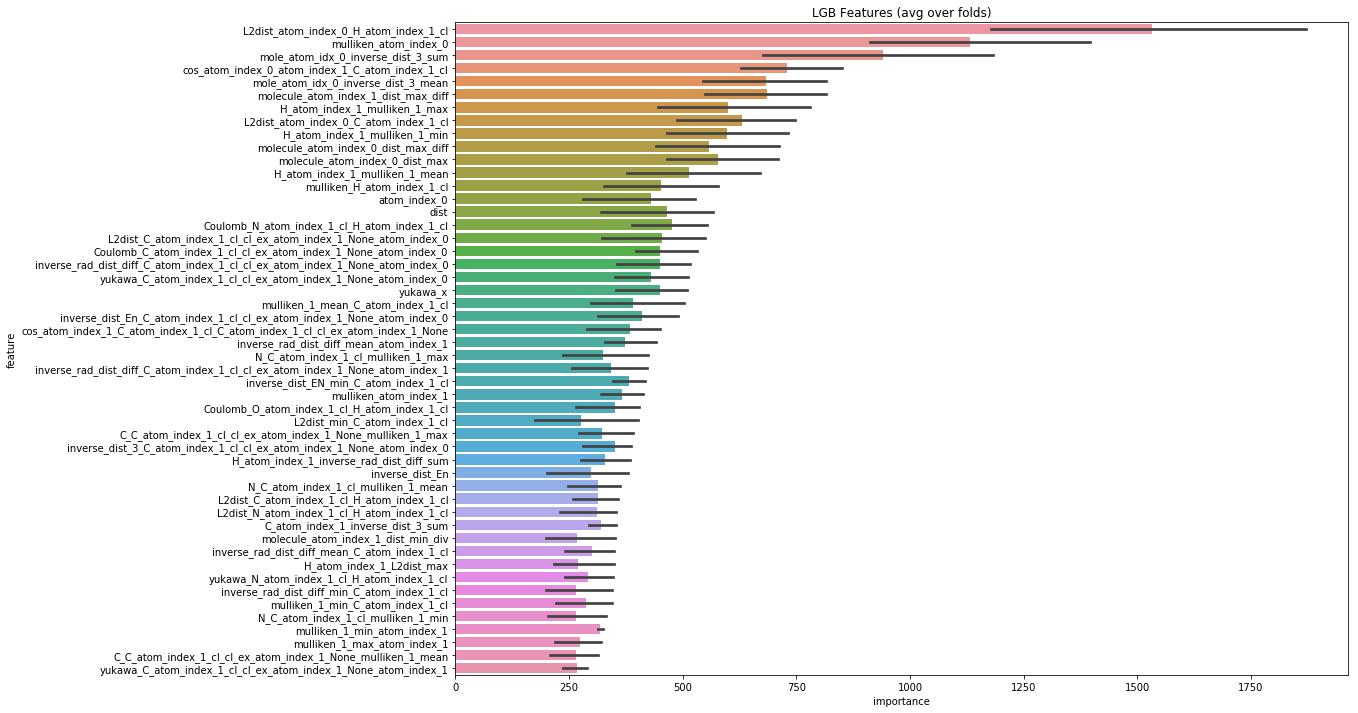

In [273]:
result_dict_lgb = train_model_regression(X = X_t, X_test = X_test_t, y = y_t, molecules = molecules_t,
                                        params = params, folds = kf, model_type = 'lgb', eval_metric = 'mae',
                                        plot_feature_importance = True, verbose = 500, early_stopping_rounds = 200,
                                        n_estimators = 1500)

In [223]:
feature_importance = result_dict_lgb['feature_importance']
cols_useless = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[-280:]

In [224]:
cols_useless.head()

,importance
feature,
inverse_rad_dist_diff_atom_index_1_N_atom_index_1_cl,0.0
C_O_atom_index_1_cl_inverse_dist_3_sum,0.0
C_O_atom_index_1_cl_inverse_dist_EN_max,0.0
inverse_rad_dist_diff_C_atom_index_1_cl_cl_ex_atom_index_1_None_O_atom_index_1_cl,0.0
inverse_rad_dist_diff_C_atom_index_1_cl_O_atom_index_1_cl,0.0


In [70]:
import queue as Q

Greedily selecting features by increasing the size of features one by one and keep the subset of features that give the best results

In [694]:
def select_features(df, start_features, features_toselect, refine_start, refine_feature, n_features, n_Estimators):
    X_t = df[features_toselect][:25000]
    X_test_t = df[features_toselect][:2000]
    y_t = df['scalar_coupling_constant'][:25000]
    molecules_t = df['molecule_name'][:25000]

    col_tokeep = []
    #features = [col for col in X_t.columns.values]
    if start_features == []:
        col_tokeep = ['dist']
        scores = [-1.]
    else:
        col_tokeep = list(start_features)
        scores = list(np.zeros(len(start_features)))
        
    duplicate_features = getDuplicateColumns(X_t[features_toselect])
    bad_col = []
    
    for iteration in range(n_features):
        print(f'Round {iteration + 1}')
        score_best = 100
        index_best = 0
        number = 0
        
        q = Q.PriorityQueue()
        
        
        for index in range(len(features_toselect)):
            
            if features_toselect[index] in col_tokeep:
                continue
            if len(X_t[features_toselect[index]].unique()) == 1:
                continue
            if features_toselect[index] in duplicate_features:
                continue
            if features_toselect[index] in bad_col:
                continue
                
            value = random()
            if iteration > 15 and value > 0.85:
                continue

            print(f'{number} feature {features_toselect[index]} started at {time.ctime()}')

            number = number + 1
            features_totest = col_tokeep.copy()
            features_totest.append(features_toselect[index])
            X_t_t = X_t[features_totest]
            X_test_t_t = X_test_t[features_totest]

            result_dict_lgb_potential = train_model_regression(X = X_t_t, X_test = X_test_t_t, y = y_t, molecules = molecules_t,
                                            params = params, folds = kf, model_type = 'lgb', eval_metric = 'mae',
                                            plot_feature_importance = False, verbose = 500, early_stopping_rounds = 200,
                                            n_estimators = n_Estimators)
            score_mean = np.mean(result_dict_lgb_potential['scores'])
            if score_mean < score_best:
                score_best = score_mean
                index_best = index
                
            if iteration > refine_start:
                q.put((-score_mean, index))

        col_tokeep.append(features_toselect[index_best])
        scores.append(score_best)
        if iteration > refine_start and iteration < 22:
            for i in range(refine_feature):
                if not q.empty():
                    temp = q.get()
                    bad_col.append(features_toselect[temp[1]])
                else:
                    break
    dict_feature = {'feature': col_tokeep, 'score': scores}
    df_feature_1J = pd.DataFrame(dict_feature)
    return df_feature_1J, col_tokeep, scores

In [232]:
kf = GroupKFold(2)

In [ ]:
df_feature_1JHN, col_tokeep, scores = select_features(train_testing_1J, [], cols_tokeep, 30, 400)

In [234]:
df_feature_1JHN.to_csv('C:/Users/tyhe1/kaggle/Molecular_properties/good_feature/gf_1JHN_20190809.csv')

In [86]:
del train_testing_1J
#del temp

### 2J 

In [147]:
train_testing_2J = train[train['type'] == '2JHH'].copy()

In [490]:
train_testing_2J = train_testing_2J[:25000]

In [148]:
train_testing_2J = train_testing_2J.loc[:,~train_testing_2J.columns.duplicated()]

In [ ]:
train_testing_2J['type'].unique()

Generate relevant secondary atoms to map out the portion of the molecule that are close to atom_index_0 and atom_index_1

In [151]:
train_testing_2J = features_closest_nonH_atom(train_testing_2J, 'atom_index_0')

In [152]:
train_testing_2J = features_closest_atom_exclude(train_testing_2J, 'atom_index_0_cl', 'atom_index_0', 'atom_index_1', 'C')

In [127]:
#If not 2JHH
train_testing_2J = features_closest_atom_exclude(train_testing_2J, 'atom_index_1', 'atom_index_0_cl', 'atom_index_0_cl', 'C')

In [128]:
# If not 2JHH
train_testing_2J = features_closest_atom_exclude(train_testing_2J, 'atom_index_1', 'atom_index_0_cl', 'atom_index_0_cl')

In [153]:
train_testing_2J = features_closest_atom_exclude(train_testing_2J, 'atom_index_0_cl', 'atom_index_1', 'atom_index_1')

In [154]:
# If 2JHH
train_testing_2J = features_closest_atom_exclude(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None', 'atom_index_0_cl', 'atom_index_0_cl')
train_testing_2J = features_closest_atom_exclude(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C', 'atom_index_0_cl', 'atom_index_0_cl')
train_testing_2J = features_closest_atom_exclude(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C', 'atom_index_0_cl', 'atom_index_0_cl', 'C')
train_testing_2J = features_closest_atom_exclude(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None', 'atom_index_0_cl', 'atom_index_0_cl', 'C')

In [155]:
cols_tokeep = [col for col in train_testing_2J.columns if col in good_feature]
train_testing_2J = train_testing_2J[cols_tokeep]

Generate relevant distances and angles and coordinates of atoms

In [131]:
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'C', 'atom_index_0_cl', 'atom_index_0')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'O', 'atom_index_0_cl', 'atom_index_0')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'N', 'atom_index_0_cl', 'atom_index_0')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'H', 'atom_index_0_cl', 'atom_index_0')

In [132]:
#If not 2JHH
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'C', 'atom_index_1', 'atom_index_0_cl')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'O', 'atom_index_1', 'atom_index_0_cl')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'N', 'atom_index_1', 'atom_index_0_cl')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'H', 'atom_index_1', 'atom_index_0_cl')

In [133]:
# If not 2JHH
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'C', 'atom_index_1_cl_ex_atom_index_0_cl_C', 'atom_index_1')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'O', 'atom_index_1_cl_ex_atom_index_0_cl_C', 'atom_index_1')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'N', 'atom_index_1_cl_ex_atom_index_0_cl_C', 'atom_index_1')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'H', 'atom_index_1_cl_ex_atom_index_0_cl_C', 'atom_index_1')

In [ ]:
# If 2JHH
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'C', 'atom_index_0_cl_cl_ex_atom_index_1_C', 'atom_index_0_cl')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'O', 'atom_index_0_cl_cl_ex_atom_index_1_C', 'atom_index_0_cl')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'N', 'atom_index_0_cl_cl_ex_atom_index_1_C', 'atom_index_0_cl')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'H', 'atom_index_0_cl_cl_ex_atom_index_1_C', 'atom_index_0_cl')

In [156]:
#For 2JHH
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'C', 'atom_index_0_cl_cl_ex_atom_index_1_None', 'atom_index_0_cl')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'O', 'atom_index_0_cl_cl_ex_atom_index_1_None', 'atom_index_0_cl')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'N', 'atom_index_0_cl_cl_ex_atom_index_1_None', 'atom_index_0_cl')
train_testing_2J = angle_dist_property_atom(train_testing_2J, 'H', 'atom_index_0_cl_cl_ex_atom_index_1_None', 'atom_index_0_cl')

In [157]:
train_testing_2J = distance(train_testing_2J, 'atom_index_0_cl', 'atom_index_1')
train_testing_2J = distance(train_testing_2J, 'atom_index_1', 'atom_index_0_cl_cl_ex_atom_index_1_C')
# If not 2JHH
#train_testing_2J = distance(train_testing_2J, 'atom_index_0', 'atom_index_1_cl_ex_atom_index_0_cl_C')
#train_testing_2J = distance(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C', 'atom_index_1_cl_ex_atom_index_0_cl_C')
#train_testing_2J = distance(train_testing_2J, 'atom_index_1', 'atom_index_0_cl_cl_ex_atom_index_1_None')
# If not 2JHH
#train_testing_2J = distance(train_testing_2J, 'atom_index_0', 'atom_index_1_cl_ex_atom_index_0_cl_None')
#train_testing_2J = distance(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None', 'atom_index_1_cl_ex_atom_index_0_cl_None')

In [158]:
#If 2JHH
train_testing_2J = distance(train_testing_2J, 'atom_index_0', 'atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_None')
train_testing_2J = distance(train_testing_2J, 'atom_index_1', 'atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_None')
train_testing_2J = distance(train_testing_2J, 'atom_index_0', 'atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_None')
train_testing_2J = distance(train_testing_2J, 'atom_index_1', 'atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_None')

train_testing_2J = distance(train_testing_2J, 'atom_index_0', 'atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_C')
train_testing_2J = distance(train_testing_2J, 'atom_index_1', 'atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_C')
train_testing_2J = distance(train_testing_2J, 'atom_index_0', 'atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_C')
train_testing_2J = distance(train_testing_2J, 'atom_index_1', 'atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_C')

In [103]:
#If not 2JHH
train_testing_2J = distance(train_testing_2J, 'C_atom_index_1_cl', 'N_atom_index_1_cl')
train_testing_2J = distance(train_testing_2J, 'C_atom_index_1_cl', 'O_atom_index_1_cl')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_1_cl', 'O_atom_index_1_cl')
train_testing_2J = distance(train_testing_2J, 'C_atom_index_1_cl', 'H_atom_index_1_cl')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_1_cl', 'H_atom_index_1_cl')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_1_cl', 'H_atom_index_1_cl')

train_testing_2J = distance(train_testing_2J, 'C_atom_index_0_cl_cl', 'N_atom_index_0_cl_cl')
train_testing_2J = distance(train_testing_2J, 'C_atom_index_0_cl_cl', 'O_atom_index_0_cl_cl')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_0_cl_cl', 'O_atom_index_0_cl_cl')
train_testing_2J = distance(train_testing_2J, 'C_atom_index_0_cl_cl', 'H_atom_index_0_cl_cl')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_0_cl_cl', 'H_atom_index_0_cl_cl')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_0_cl_cl', 'H_atom_index_0_cl_cl')

In [104]:
train_testing_2J = distance(train_testing_2J, 'C_atom_index_0_cl_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_0_cl_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_0_cl_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'H_atom_index_0_cl_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'C_atom_index_0_cl_cl', 'atom_index_1')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_0_cl_cl', 'atom_index_1')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_0_cl_cl', 'atom_index_1')
train_testing_2J = distance(train_testing_2J, 'H_atom_index_0_cl_cl', 'atom_index_1')
#If not 2JHH
train_testing_2J = distance(train_testing_2J, 'C_atom_index_1_cl', 'atom_index_0_cl')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_1_cl', 'atom_index_0_cl')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_1_cl', 'atom_index_0_cl')
train_testing_2J = distance(train_testing_2J, 'H_atom_index_1_cl', 'atom_index_0_cl')
#If not 2JHH
train_testing_2J = distance(train_testing_2J, 'C_atom_index_1_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_1_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_1_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'H_atom_index_1_cl', 'atom_index_0')


In [ ]:
# If 2JHH
train_testing_2J = distance(train_testing_2J, 'C_atom_index_0_cl_cl_ex_atom_index_1_C_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'C_atom_index_0_cl_cl_ex_atom_index_1_C_cl', 'atom_index_1')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_0_cl_cl_ex_atom_index_1_C_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_0_cl_cl_ex_atom_index_1_C_cl', 'atom_index_1')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_0_cl_cl_ex_atom_index_1_C_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_0_cl_cl_ex_atom_index_1_C_cl', 'atom_index_1')
train_testing_2J = distance(train_testing_2J, 'H_atom_index_0_cl_cl_ex_atom_index_1_C_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'H_atom_index_0_cl_cl_ex_atom_index_1_C_cl', 'atom_index_1')
# If 2JHH
train_testing_2J = distance(train_testing_2J, 'C_atom_index_0_cl_cl_ex_atom_index_1_None_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'C_atom_index_0_cl_cl_ex_atom_index_1_None_cl', 'atom_index_1')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_0_cl_cl_ex_atom_index_1_None_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_0_cl_cl_ex_atom_index_1_None_cl', 'atom_index_1')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_0_cl_cl_ex_atom_index_1_None_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_0_cl_cl_ex_atom_index_1_None_cl', 'atom_index_1')
train_testing_2J = distance(train_testing_2J, 'H_atom_index_0_cl_cl_ex_atom_index_1_None_cl', 'atom_index_0')
train_testing_2J = distance(train_testing_2J, 'H_atom_index_0_cl_cl_ex_atom_index_1_None_cl', 'atom_index_1')

In [105]:
#If not 2JHH
train_testing_2J = distance(train_testing_2J, 'C_atom_index_1_cl', 'atom_index_1_cl_ex_atom_index_0_cl_C')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_1_cl', 'atom_index_1_cl_ex_atom_index_0_cl_C')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_1_cl', 'atom_index_1_cl_ex_atom_index_0_cl_C')
train_testing_2J = distance(train_testing_2J, 'H_atom_index_1_cl', 'atom_index_1_cl_ex_atom_index_0_cl_C')
#If not 2JHH
train_testing_2J = distance(train_testing_2J, 'C_atom_index_1_cl', 'atom_index_1_cl_ex_atom_index_0_cl_None')
train_testing_2J = distance(train_testing_2J, 'N_atom_index_1_cl', 'atom_index_1_cl_ex_atom_index_0_cl_None')
train_testing_2J = distance(train_testing_2J, 'O_atom_index_1_cl', 'atom_index_1_cl_ex_atom_index_0_cl_None')
train_testing_2J = distance(train_testing_2J, 'H_atom_index_1_cl', 'atom_index_1_cl_ex_atom_index_0_cl_None')

In [159]:
train_testing_2J = add_cos_features(train_testing_2J, 'atom_index_0', 'atom_index_0_cl', 'atom_index_1')
train_testing_2J = add_cos_features(train_testing_2J, 'atom_index_1', 'atom_index_0_cl', 'atom_index_0_cl_cl_ex_atom_index_1_C')
train_testing_2J = add_cos_features(train_testing_2J, 'atom_index_1', 'atom_index_0_cl', 'atom_index_0_cl_cl_ex_atom_index_1_None')

In [160]:
cols_tokeep = [col for col in train_testing_2J.columns if col in good_feature]
train_testing_2J = train_testing_2J[cols_tokeep]

aggregation features

In [161]:
#If not 2JHH
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1', 'O')
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1', 'N')
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1', 'C')
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1', 'H')

train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl', 'O')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl', 'N')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl', 'C')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl', 'H')

cols_tokeep = [col for col in train_testing_2J.columns if col in good_feature]
train_testing_2J = train_testing_2J[cols_tokeep]

train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C', 'O')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C', 'N')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C', 'C')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C', 'H')
# If not 2JHH
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1_cl_ex_atom_index_0_cl_C', 'O')
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1_cl_ex_atom_index_0_cl_C', 'N')
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1_cl_ex_atom_index_0_cl_C', 'C')
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1_cl_ex_atom_index_0_cl_C', 'H')

train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None', 'O')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None', 'N')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None', 'C')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None', 'H')
#If not 2JHH
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1_cl_ex_atom_index_0_cl_None', 'O')
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1_cl_ex_atom_index_0_cl_None', 'N')
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1_cl_ex_atom_index_0_cl_None', 'C')
#train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_1_cl_ex_atom_index_0_cl_None', 'H')

In [162]:
#If 2JHH
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_None', 'O')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_None', 'N')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_None', 'C')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_None', 'H')

train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_None', 'O')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_None', 'N')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_None', 'C')
train_testing_2J = aggregate_features_connected_atom(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_None', 'H')

In [163]:
cols_tokeep = [col for col in train_testing_2J.columns if col in good_feature]
train_testing_2J = train_testing_2J[cols_tokeep]

In [164]:
train_testing_2J = aggregate_bonds(train_testing_2J, 'atom_index_1')
train_testing_2J = aggregate_bonds(train_testing_2J, 'atom_index_0_cl')
train_testing_2J = aggregate_bonds(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C')
# If not 2JHH
#train_testing_2J = aggregate_bonds(train_testing_2J, 'atom_index_1_cl_ex_atom_index_0_cl_C')

train_testing_2J = aggregate_bonds(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None')
# If not 2JHH
#train_testing_2J = aggregate_bonds(train_testing_2J, 'atom_index_1_cl_ex_atom_index_0_cl_None')

In [165]:
#If 2JHH
train_testing_2J = aggregate_bonds(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_None')
train_testing_2J = aggregate_bonds(train_testing_2J, 'atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_None')

In [166]:
cols_tokeep = [col for col in train_testing_2J.columns if col in good_feature]
train_testing_2J = train_testing_2J[cols_tokeep]

In [167]:
df_feature_2J = pd.read_csv('C:/Users/tyhe1/kaggle/Molecular_properties/good_feature/gf_2JHH_20190809.csv')
all_feature = list(df_feature_2J['feature'].values) + list(['molecule_name', 'atom_index_0', 'atom_index_1'])
len(all_feature)

39

In [946]:
train_testing_2J[all_feature].head()

,dist,inverse_dist_EN_sum_atom_index_0_cl,inverse_dist_En_atom_index_0_atom_index_1_cl_ex_atom_index_0_cl_None,inverse_dist_EN_sum_atom_index_1,H_atom_index_0_cl_inverse_dist_3_sum,cos_closest_0,inverse_dist_En_atom_index_1_atom_index_0_cl_cl_ex_atom_index_1_None,inverse_dist_EN_sum_atom_index_0_cl_cl_ex_atom_index_1_None,inverse_dist_EN_min_atom_index_1,O_atom_index_0_cl_inverse_dist_3_min,...,L2dist_atom_index_1_atom_index_0_cl_cl_ex_atom_index_1_None,inverse_dist_EN_atom_index_1_atom_index_1_cl_ex_atom_index_0_cl_None,C_atom_index_1_inverse_dist_3_sum,O_atom_index_1_inverse_dist_3_min,C_atom_index_0_cl_cl_ex_atom_index_1_None_Coulomb_min,inverse_rad_dist_diff_mean_atom_index_0_cl_cl_ex_atom_index_1_None,inverse_dist_EN_mean_atom_index_1,molecule_name,atom_index_0,atom_index_1
0,2.182492,0.632615,-1.0,0.632615,2.618327,0.757919,-1.0,-1.0,0.124345,-1.0,...,-1.0,100.0,0.528592,-1.0,-1.0,-1.0,0.158154,dsgdb9nsd_000007,2,1
1,2.182487,0.632615,-1.0,0.632615,2.618327,0.105960,-1.0,-1.0,0.124345,-1.0,...,-1.0,100.0,0.528592,-1.0,-1.0,-1.0,0.158154,dsgdb9nsd_000007,3,1
2,2.182539,0.632615,-1.0,0.632615,2.618327,0.105960,-1.0,-1.0,0.124345,-1.0,...,-1.0,100.0,0.528592,-1.0,-1.0,-1.0,0.158154,dsgdb9nsd_000007,4,1
3,2.182485,0.632615,-1.0,0.632615,2.618328,0.105949,-1.0,-1.0,0.124345,-1.0,...,-1.0,100.0,0.528592,-1.0,-1.0,-1.0,0.158154,dsgdb9nsd_000007,5,0
4,2.182485,0.632615,-1.0,0.632615,2.618328,0.757911,-1.0,-1.0,0.124345,-1.0,...,-1.0,100.0,0.528592,-1.0,-1.0,-1.0,0.158154,dsgdb9nsd_000007,6,0


In [168]:
train_testing_2J = train_testing_2J[all_feature]

In [169]:
train_testing_2J = reduce_mem_usage(train_testing_2J)

Mem. usage decreased to 31.38 Mb (49.4% reduction)


In [170]:
train_testing_2J.to_csv('C:/Users/tyhe1/kaggle/Molecular_properties/20190822/test_2JHH.csv')

In [ ]:
train_testing_2J.head()

In [505]:
cols_tokeep = [ col for col in train_testing_2J.columns.values if col not in [ 'atom_0', 'atom_1', 'atom_0_closest', 'atom_1_closest',
                     'type_0', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'scalar_coupling_constant', 'x_0_closest', 'y_0_closest', 
                     'z_0_closest', 'x_1_closest', 'y_1_closest', 'z_1_closest', 'type', 'scalar_coupling_constant_x',
                    'x_atom_index_1_closest', 'y_atom_index_1_closest', 'z_atom_index_1_closest', 'moelcule_name', 'scalar_coupling_constant_y',
                   'x_closest_0', 'y_closest_0', 'z_closest_0', 'x_atom_index_1', 'y_atom_index_1', 'z_atom_index_1',
                   'x_closest_1', 'y_closest_1', 'z_closest_1', 'x_atom_index_0', 'y_atom_index_0', 'z_atom_index_0',
                   'molecule_atom_index_0_dist_min', 'n_bonds_0', 'molecule_name', 'magnitude_0', 'magnitude_1', 'multiply_magnitude',
                    'oof', 'target', 'O_bond_lengths_mean_sum', 'C_bond_lengths_mean_sum', 'total_atom_number',
                     'x_atom_index_0', 'x_atom_index_0_cl_cl_ex_atom_index_1', 'x_atom_index_0_cl_cl_ex_atom_index_1', 'dist_x', 'dist_y', 'dist_z','id'] ]

In [506]:
cols_tokeep = [col for col in cols_tokeep if #str('x_atom') not in col and 
               str('y_atom') not in col and str('z_atom') not in col and str('x_C_atom') not in col and str('y_C_atom') not in col and str('z_C_atom') not in col
               and str('x_H_atom') not in col and str('y_H_atom') not in col and str('z_H_atom') not in col and str('x_N_atom') not in col and str('y_N_atom') not in col and str('z_N_atom') not in col
                and str('x_O_atom') not in col and str('y_O_atom') not in col and str('z_O_atom') not in col]

In [514]:
cols_tokeep = [col for col in cols_tokeep if col not in cols_useless.index]

In [ ]:
def feature_selection_pearson(X, y):
    pcol = []
    pcor = []
    pval = []
    #y_value = y['time_to_failure'].values

    for col in X.columns:
        pcol.append(col)
        pcor.append(abs(stats.pearsonr(X[col], y)[0]))
        pval.append(abs(stats.pearsonr(X[col], y)[1]))

    df = pd.DataFrame(data={'col': pcol, 'cor': pcor, 'pval': pval}, index=range(len(pcol)))
    df.sort_values(by=['cor', 'pval'], inplace=True)
    df.dropna(inplace=True)
    df = df.loc[df['pval'] == 0.0]

    drop_cols = []

    for col in X.columns:
        if col not in df['col'].tolist():
            drop_cols.append(col)
    return drop_cols

In [426]:
drop_cols = feature_selection_pearson(train_testing_2J[cols_tokeep][:25000], train_testing_2J['scalar_coupling_constant'][:25000], 0.05)
len(drop_cols)

54

In [ ]:
cols_tokeep = [col for col in cols_tokeep if col not in drop_cols]

In [515]:
X_t = train_testing_2J[cols_tokeep][:25000]
X_test_t = train_testing_2J[cols_tokeep][:2000]
y_t = train_testing_2J['scalar_coupling_constant'][:25000]
molecules_t = train_testing_2J['molecule_name'][:25000]

In [ ]:
#  0.1806        2JHN: 0.221    2JHC: 0.4985    2JHH: 0.2190

In [509]:
params = {
    'num_leaves': 200,
    'min_child_samples': 79,
    'objective': 'huber',
    'colsample_bytree': 0.7,
    'subsample': 0.8,
    'eta': 0.3,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'metric': 'mae'
}

In [510]:
kf = GroupKFold(2)

Fold 1 started at Sat Aug 17 13:26:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's l1: 0.0599869	valid_1's l1: 0.215846
Fold 2 started at Sat Aug 17 13:27:15 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's l1: 0.0605804	valid_1's l1: 0.222218
CV mean score: 0.2190, std: 0.0032.


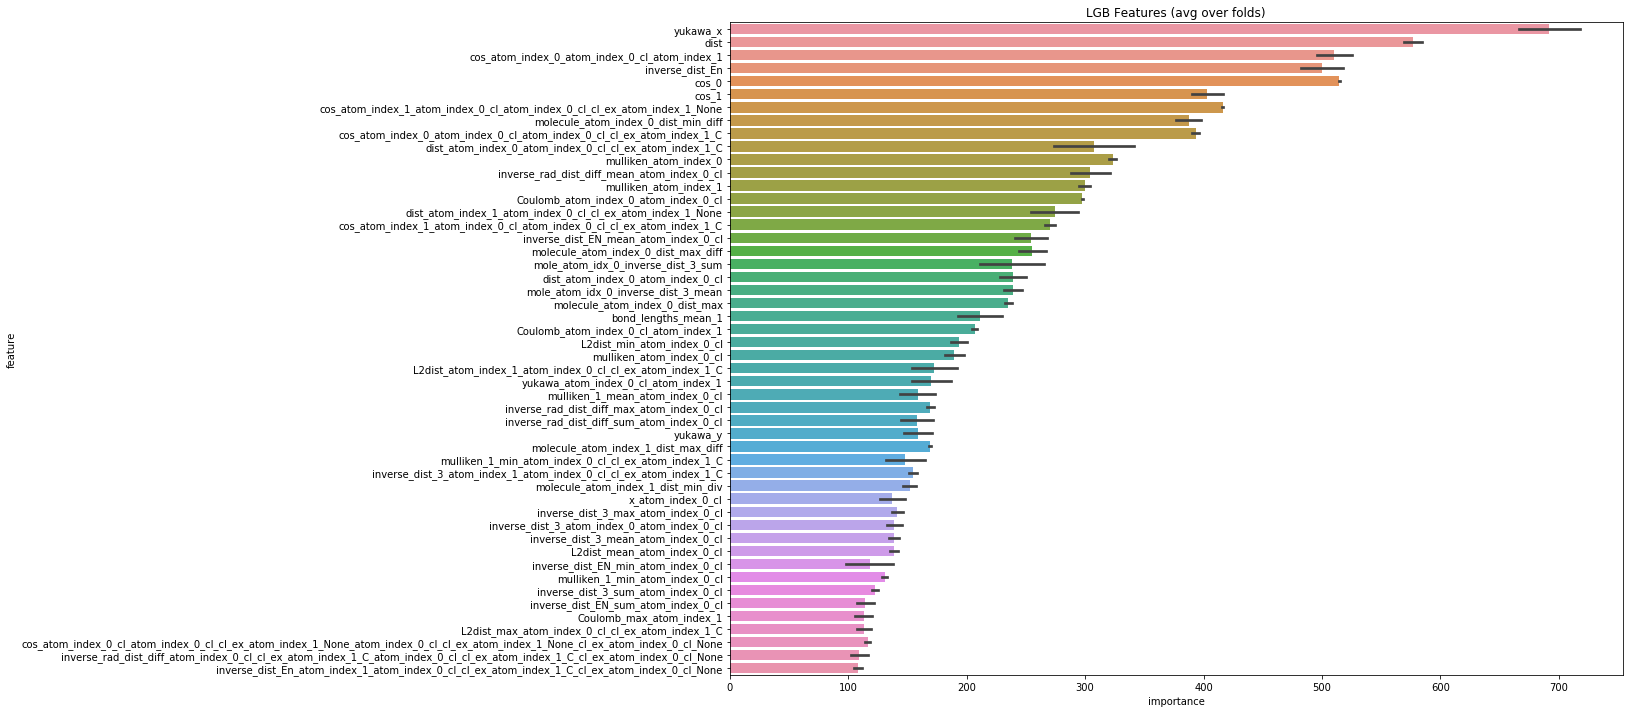

In [517]:
result_dict_lgb = train_model_regression(X = X_t, X_test = X_test_t, y = y_t, molecules = molecules_t,
                                        params = params, folds = kf, model_type = 'lgb', eval_metric = 'mae',
                                        plot_feature_importance = True, verbose = 500, early_stopping_rounds = 200,
                                        n_estimators = 400)

In [512]:
feature_importance = result_dict_lgb['feature_importance']
cols_useless = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[-80:]

In [513]:
cols_useless.head()

,importance
feature,
nbond_min_atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_None,0.25
EN_atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_None,0.25
N_atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_None_nbond_mean,0.25
nbond_mean_atom_index_0_cl_cl_ex_atom_index_1_None_cl_ex_atom_index_0_cl_None,0.25
N_atom_index_0_cl_cl_ex_atom_index_1_C_cl_ex_atom_index_0_cl_None_yukawa_min,0.25


In [ ]:
feature_importance.reset_index(inplace = True)

In [ ]:
df_feature_2JHH, col_tokeep, scores = select_features(train_testing_2J, [], cols_tokeep, 13, 40, 35, 400)

In [ ]:
df_feature_2JHH.to_csv('C:/Users/tyhe1/kaggle/Molecular_properties/good_feature/gf_2JHH_20190809.csv')

In [951]:
del train_testing_2J

### 3J

In [248]:
train_testing_3J = train[train['type'] == '3JHN'].copy()

In [700]:
train_testing_3J = train_testing_3J[:25000]

In [249]:
train_testing_3J = train_testing_3J.loc[:,~train_testing_3J.columns.duplicated()]

In [ ]:
train_testing_3J.drop(['bond_0_0closest', 'bond_0_1closest', 'bond_1_0closest', 'bond_1_1closest', 'bond_1closest_0closest'], axis = 1, inplace = True)

In [ ]:
train_testing_3J['type'].unique()

In [ ]:
train_bonds.columns[train_bonds.isna().any()].tolist()

Generate relevant secondary atoms to map out the portion of the molecule that are close to atom_index_0 and atom_index_1

In [252]:
train_testing_3J = features_closest_nonH_atom(train_testing_3J, 'atom_index_0')

Get the atom between start_atom_index and end_atom_index

In [179]:
def atom_between(df, start_atom_index, end_atom_index):
    temp = train_bonds[train_bonds['atom_1'] != 'H']
    temp_2 = temp.copy()
    
    temp = pd.merge(temp[['molecule_name', 'ATOM_INDEX_1', 'ATOM_INDEX_0']], temp_2[['molecule_name', 'ATOM_INDEX_1', 'ATOM_INDEX_0']], how = 'left',
                  left_on  = ['molecule_name', 'ATOM_INDEX_1'],
                  right_on = ['molecule_name',  'ATOM_INDEX_1'])
    
    temp_cl = temp.groupby(['molecule_name', 'ATOM_INDEX_0_x', 'ATOM_INDEX_0_y']).nth(0)
    temp_cl.reset_index(inplace = True)

    atom_cl = f'{start_atom_index}_{end_atom_index}_mid'
    df = pd.merge(df, temp_cl, how = 'left',
                           left_on = ['molecule_name', start_atom_index, end_atom_index],
                           right_on = ['molecule_name', 'ATOM_INDEX_0_x', 'ATOM_INDEX_0_y'])
    df.drop(['ATOM_INDEX_0_x', 'ATOM_INDEX_0_y'], axis = 1, inplace = True)
    df.rename(columns = {'ATOM_INDEX_1': atom_cl}, inplace = True)
    
    df = pd.merge(df, structures[['molecule_name', 'atom_index', 'mulliken', 'x', 'y', 'z', 'EN', 'rad']], how = 'left',
                  left_on  = ['molecule_name', atom_cl],
                  right_on = ['molecule_name', 'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    
    df = df.rename(columns={'x': f'x_{atom_cl}',
                            'y': f'y_{atom_cl}',
                            'z': f'z_{atom_cl}',
                            'mulliken': f'mulliken_{atom_cl}',
                            'EN': f'EN_{atom_cl}',
                            'rad': f'rad_{atom_cl}'
                           })
    values = {f'x_{atom_cl}': 0,
              f'y_{atom_cl}': 0,
              f'z_{atom_cl}': 0,
             f'mulliken_{atom_cl}': -1,
              f'EN_{atom_cl}': -1,
             f'rad_{atom_cl}': -1
             }
    df.fillna(value = values, inplace = True)
    
        
    del temp
    del temp_2
        
    return df

Get the number of bonds and other relevant properties between atom_index_start and atom_index_end

In [180]:
def nbond_between_atoms(df, atom_index_start, atom_index_end):
    df = pd.merge(df, train_bonds[['molecule_name', 'ATOM_INDEX_0', 'ATOM_INDEX_1', 'nbond',
                                   'Coulomb', 'yukawa', 'inverse_dist_3', 'inverse_rad_dist_diff', 'inverse_dist_EN'
                             
                                  ]], how = 'left',
                  left_on  = ['molecule_name', atom_index_start, atom_index_end],
                  right_on = ['molecule_name',  'ATOM_INDEX_0', 'ATOM_INDEX_1'])

    df.drop(['ATOM_INDEX_0', 'ATOM_INDEX_1'], axis = 1, inplace = True)

    df = df.rename(columns={#'L2dist': f'L2dist_{source_atom_index}_cl_ex_{atom_index_exclude}_{atom}',
                              'nbond': f'nbond_{atom_index_start}_{atom_index_end}',
                              'Coulomb': f'Coulomb_{atom_index_start}_{atom_index_end}',
                              'yukawa': f'yukawa_{atom_index_start}_{atom_index_end}',
                              'inverse_dist_3': f'inverse_dist_3_{atom_index_start}_{atom_index_end}',
                              'inverse_rad_dist_diff': f'inverse_rad_dist_diff_{atom_index_start}_{atom_index_end}',
                              'inverse_dist_EN': f'inverse_dist_EN_{atom_index_start}_{atom_index_end}'
                           })
    
    values = {
             f'nbond_{atom_index_start}_{atom_index_end}': -1,
             f'Coulomb_{atom_index_start}_{atom_index_end}': 100,
             f'yukawa_{atom_index_start}_{atom_index_end}': 100,
             f'inverse_dist_3_{atom_index_start}_{atom_index_end}': 100,
             f'inverse_rad_dist_diff_{atom_index_start}_{atom_index_end}': 100,
             f'inverse_dist_EN_{atom_index_start}_{atom_index_end}': 100
             }
    df.fillna(value = values, inplace = True)
    
    return df

In [253]:
train_testing_3J = atom_between(train_testing_3J, 'atom_index_0_cl', 'atom_index_1')

In [191]:
#If 3JHH
train_testing_3J = features_closest_atom_exclude(train_testing_3J, 'atom_index_0_cl', 'atom_index_0', 'atom_index_0_cl_atom_index_1_mid', 'C')
train_testing_3J = features_closest_atom_exclude(train_testing_3J, 'atom_index_0_cl', 'atom_index_0', 'atom_index_0_cl_atom_index_1_mid')

train_testing_3J = features_closest_atom_exclude(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1', 'atom_index_0_cl', 'C')
train_testing_3J = features_closest_atom_exclude(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1', 'atom_index_0_cl')

In [223]:
def features_closest_atom_exclude_multiple(df, source_atom_index, start_atom_index, arr_atom_index_exclude, atom = None):
    if atom == None:
        temp = train_bonds[train_bonds['atom_1'] != 'H']
    else:
        temp = train_bonds[train_bonds['atom_1'] == atom]
    cols = list(arr_atom_index_exclude).copy()
    cols.append(source_atom_index)
    cols.append('molecule_name')
    temp_2 = df[cols].copy()
    temp_2.drop_duplicates(inplace = True)

    temp_3 = pd.merge(temp, temp_2, how = 'right', 
                 left_on = ['molecule_name', 'ATOM_INDEX_0'],
                right_on = ['molecule_name', source_atom_index])
    for atom_index_exclude in arr_atom_index_exclude:
        temp_3 = temp_3[temp_3['ATOM_INDEX_1'] != temp_3[atom_index_exclude]]
    temp_3.dropna(inplace = True)
    temp_3 = temp_3.groupby(['molecule_name', 'ATOM_INDEX_0']).nth(0)
    temp_3.reset_index(inplace = True)

    df = pd.merge(df, temp_3[['molecule_name', 'ATOM_INDEX_0', 'ATOM_INDEX_1', 'L2dist', 'nbond', 
                              'mulliken_1', 'Coulomb', 'yukawa', 'inverse_dist_3', 'inverse_rad_dist_diff', 'inverse_dist_EN'
                             ]], how = 'left',
                  left_on  = ['molecule_name', source_atom_index],
                  right_on = ['molecule_name',  'ATOM_INDEX_0'])

    df.drop('ATOM_INDEX_0', axis = 1, inplace = True)

    df = df.rename(columns={'ATOM_INDEX_1': f'{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}',
                              'L2dist': f'L2dist_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}',
                              'nbond': f'nbond_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}',
                              #'atom_1': 'C_atom_1_closest_closest',
                            'mulliken_1': f'mulliken_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}',
                            'Coulomb': f'Coulomb_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}',
                            'yukawa': f'yukawa_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}',
                            'inverse_dist_3': f'inverse_dist_3_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}',
                            'inverse_rad_dist_diff': f'inverse_rad_dist_diff_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}',
                            'inverse_dist_EN': f'inverse_dist_EN_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}'
                           })
    
    values = {f'{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}': -1,
             f'L2dist_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}': -1,
             f'nbond_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}': -1,
             #'C_atom_1_closest_closest': 'X',
              f'mulliken_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}': -1,
             f'Coulomb_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}': 100,
             f'yukawa_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}': 100,
             f'inverse_dist_3_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}': 100,
             f'inverse_rad_dist_diff_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}': 100,
             f'inverse_dist_EN_{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}': 100
             }
    df.fillna(value = values, inplace = True)
    
    atom_cl = f'{source_atom_index}_cl_ex_{len(arr_atom_index_exclude)}_{atom}'
    
    df = pd.merge(df, structures[['molecule_name', 'atom_index', 'x', 'y', 'z', 'EN', 'rad']], how = 'left',
                  left_on  = ['molecule_name', atom_cl],
                  right_on = ['molecule_name', 'atom_index'])

    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'x': f'x_{atom_cl}',
                            'y': f'y_{atom_cl}',
                            'z': f'z_{atom_cl}',
                            'EN': f'EN_{atom_cl}',
                            'rad': f'rad_{atom_cl}'
                           })
    values = {f'x_{atom_cl}': 0,
              f'y_{atom_cl}': 0,
              f'z_{atom_cl}': 0,
              f'EN_{atom_cl}': -1,
              f'rad_{atom_cl}': -1,
             }
    df.fillna(value = values, inplace = True)
        
    df = add_cos_features(df, start_atom_index, source_atom_index, atom_cl)    
    df[f'dist_{start_atom_index}_{atom_cl}'] = (df[f'x_{start_atom_index}'] - df[f'x_{atom_cl}']) ** 2 + (df[f'y_{start_atom_index}'] - df[f'y_{atom_cl}']) ** 2 + (df[f'z_{start_atom_index}'] - df[f'z_{atom_cl}']) ** 2
    df.loc[(df[f'x_{atom_cl}'] == 0.) & (df[f'y_{atom_cl}'] == 0.) & (df[f'z_{atom_cl}'] == 0.), f'dist_{start_atom_index}_{atom_cl}'] = 0
    #del temp_2
        
    return df

In [254]:
#If not 3JHH
train_testing_3J = features_closest_atom_exclude(train_testing_3J, 'atom_index_0_cl', 'atom_index_0', 'atom_index_0_cl_atom_index_1_mid', 'C')
train_testing_3J = features_closest_atom_exclude(train_testing_3J, 'atom_index_0_cl', 'atom_index_0', 'atom_index_0_cl_atom_index_1_mid')
train_testing_3J = features_closest_atom_exclude_multiple(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1', ['atom_index_0_cl', 'atom_index_1'], 'C')
train_testing_3J = features_closest_atom_exclude_multiple(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1', ['atom_index_0_cl', 'atom_index_1'])
train_testing_3J = features_closest_atom_exclude(train_testing_3J, 'atom_index_1', 'atom_index_0_cl_atom_index_1_mid', 'atom_index_0_cl_atom_index_1_mid', 'C')
train_testing_3J = features_closest_atom_exclude(train_testing_3J, 'atom_index_1', 'atom_index_0_cl_atom_index_1_mid', 'atom_index_0_cl_atom_index_1_mid')

In [255]:
cols_tokeep = [col for col in train_testing_3J.columns if col in good_feature]
train_testing_3J = train_testing_3J[cols_tokeep]

angle and distance properties

In [ ]:
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'C', 'atom_index_0_cl', 'atom_index_0')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'O', 'atom_index_0_cl', 'atom_index_0')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'N', 'atom_index_0_cl', 'atom_index_0')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'H', 'atom_index_0_cl', 'atom_index_0')

#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'C', 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'O', 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'N', 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'H', 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1')

In [ ]:
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'C', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'O', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'N', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'H', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0')

#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'C', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'O', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'N', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0')
#train_testing_3J = angle_dist_property_atom(train_testing_3J, 'H', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0')

In [256]:
train_testing_3J = nbond_between_atoms(train_testing_3J, 'atom_index_0_cl', 'atom_index_0_cl_atom_index_1_mid')
train_testing_3J = nbond_between_atoms(train_testing_3J, 'atom_index_1', 'atom_index_0_cl_atom_index_1_mid')

In [257]:
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl', 'atom_index_0_cl_atom_index_1_mid')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1')
train_testing_3J = distance(train_testing_3J, 'atom_index_0', 'atom_index_0_cl_atom_index_1_mid')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl', 'atom_index_1')

In [196]:
#If 3JHH
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_1')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0_cl_atom_index_1_mid')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_C', 'atom_index_0')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_C', 'atom_index_0_cl')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_C', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C')

train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_1')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0_cl_atom_index_1_mid')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_None', 'atom_index_0')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_None', 'atom_index_0_cl')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_None', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None')

In [258]:
#If not 3JHH
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_1')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0_cl_atom_index_1_mid')

train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_1')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0_cl_atom_index_1_mid')

train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None', 'atom_index_0')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None', 'atom_index_0_cl')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C')

train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C', 'atom_index_0')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C', 'atom_index_0_cl')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None')
train_testing_3J = distance(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C')

train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0')
train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0_cl')
train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None')
train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C')
train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C')
train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None')

train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0')
train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0_cl')
train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None')
train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C')
train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C')
train_testing_3J = distance(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None')

In [259]:
train_testing_3J = add_cos_features(train_testing_3J, 'atom_index_0', 'atom_index_0_cl', 'atom_index_0_cl_atom_index_1_mid')
train_testing_3J = add_cos_features(train_testing_3J, 'atom_index_0_cl', 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1')
train_testing_3J = add_cos_features(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'atom_index_0_cl', 'atom_index_0_cl_atom_index_1_mid')
train_testing_3J = add_cos_features(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'atom_index_0_cl', 'atom_index_0_cl_atom_index_1_mid')
#If 3JHH
#train_testing_3J = add_cos_features(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_None', 'atom_index_0_cl_atom_index_1_mid', 'atom_index_0_cl')
#train_testing_3J = add_cos_features(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_C', 'atom_index_0_cl_atom_index_1_mid', 'atom_index_0_cl')

Suppose vec_1 = (atom_index_start_1, atom_index_end_1), vec_2 = (atom_index_start_2, atom_index_end_2)
Get the angle between vec_1 and vec_2

In [260]:
def add_cos_features_two_vec(df, atom_index_start_1, atom_index_end_1, atom_index_start_2, atom_index_end_2):
    
    df["distance_0"]=((df[f'x_{atom_index_start_1}']-df[f'x_{atom_index_end_1}'])**2+(df[f'y_{atom_index_start_1}']-df[f'y_{atom_index_end_1}'])**2+(df[f'z_{atom_index_start_1}']-df[f'z_{atom_index_end_1}'])**2)**(1/2)
    df["distance_1"]=((df[f'x_{atom_index_start_2}']-df[f'x_{atom_index_end_2}'])**2+(df[f'y_{atom_index_start_2}']-df[f'y_{atom_index_end_2}'])**2+(df[f'z_{atom_index_start_2}']-df[f'z_{atom_index_end_2}'])**2)**(1/2)
    
    df["vec_x_1"]=(df[f'x_{atom_index_end_1}']-df[f'x_{atom_index_start_1}'])/df["distance_0"]
    df["vec_y_1"]=(df[f'y_{atom_index_end_1}']-df[f'y_{atom_index_start_1}'])/df["distance_0"]
    df["vec_z_1"]=(df[f'z_{atom_index_end_1}']-df[f'z_{atom_index_start_1}'])/df["distance_0"]
    df["vec_x_2"]=(df[f'x_{atom_index_end_2}']-df[f'x_{atom_index_start_2}'])/df["distance_1"]
    df["vec_y_2"]=(df[f'y_{atom_index_end_2}']-df[f'y_{atom_index_start_2}'])/df["distance_1"]
    df["vec_z_2"]=(df[f'z_{atom_index_end_2}']-df[f'z_{atom_index_start_2}'])/df["distance_1"]
    
    df[f"cos_{atom_index_end_1}_{atom_index_start_1}_{atom_index_start_2}_{atom_index_end_2}"]=df["vec_x_1"]*df["vec_x_2"]+df["vec_y_1"]*df["vec_y_2"]+df["vec_z_1"]*df["vec_z_2"]
    
    df=df.drop(['vec_x_1','vec_y_1','vec_z_1','vec_x_2','vec_y_2','vec_z_2', 'distance_0', 'distance_1'
               ], axis=1)
    return df

In [261]:
train_testing_3J = add_cos_features_two_vec(train_testing_3J, 'atom_index_0_cl', 'atom_index_0', 'atom_index_0_cl_atom_index_1_mid', 'atom_index_1')

In [262]:
cols_tokeep = [col for col in train_testing_3J.columns if col in good_feature]
train_testing_3J = train_testing_3J[cols_tokeep]

Aggregate features

In [263]:
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl', 'H')

In [264]:
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid', 'H')

In [265]:
cols_tokeep = [col for col in train_testing_3J.columns if col in good_feature]
train_testing_3J = train_testing_3J[cols_tokeep]

In [204]:
# If 3JHH
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'H')

train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'H')

cols_tokeep = [col for col in train_testing_3J.columns if col in good_feature]
train_testing_3J = train_testing_3J[cols_tokeep]

train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_C', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_C', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_C', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_C', 'H')

train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_None', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_None', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_None', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_None', 'H')

In [266]:
# If not 3JHH 
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1', 'H')

train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'H')

train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'H')

cols_tokeep = [col for col in train_testing_3J.columns if col in good_feature]
train_testing_3J = train_testing_3J[cols_tokeep]

train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None', 'H')

train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C', 'H')

train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C', 'H')

cols_tokeep = [col for col in train_testing_3J.columns if col in good_feature]
train_testing_3J = train_testing_3J[cols_tokeep]

train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None', 'O')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None', 'N')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None', 'C')
train_testing_3J = aggregate_features_connected_atom(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None', 'H')

In [267]:
cols_tokeep = [col for col in train_testing_3J.columns if col in good_feature]
train_testing_3J = train_testing_3J[cols_tokeep]

In [268]:
train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_0_cl')
train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid')

In [269]:
train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C')
train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None')
#If 3JHH
#train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_C')
#train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_atom_index_0_cl_None')

In [270]:
#If not 3JHH
train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_1')
train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None')
train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_C')
train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_C')
train_testing_3J = aggregate_bonds(train_testing_3J, 'atom_index_0_cl_atom_index_1_mid_cl_ex_2_None')

In [271]:
cols_tokeep = [col for col in train_testing_3J.columns if col in good_feature]
train_testing_3J = train_testing_3J[cols_tokeep]

In [272]:
df_feature_3J = pd.read_csv('C:/Users/tyhe1/kaggle/Molecular_properties/good_feature/gf_3JHN_20190809.csv')
all_feature = list(df_feature_3J['feature'].values) + list(['molecule_name', 'atom_index_0', 'atom_index_1'])
len(all_feature)

39

In [273]:
train_testing_3J = train_testing_3J[all_feature]

In [276]:
train_testing_3J.head()

,dist,inverse_dist_EN_sum_atom_index_0_cl,cos_0,inverse_dist_EN_sum_atom_index_1,inverse_dist_EN_sum_atom_index_0_cl_atom_index_1_mid,cos_1,inverse_dist_En_atom_index_0_atom_index_0_cl_atom_index_1_mid,inverse_dist_En_atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None_atom_index_0_cl,cos_atom_index_0_atom_index_0_cl_atom_index_0_cl_atom_index_1_mid_atom_index_1,inverse_dist_3_atom_index_0_cl_atom_index_1,...,C_atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_None_inverse_dist_3_mean,C_atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None_mulliken_1_mean,O_atom_index_1_cl_ex_atom_index_0_cl_atom_index_1_mid_None_L2dist_min,inverse_dist_3_max_atom_index_0_cl_atom_index_1_mid,dist_atom_index_1_atom_index_0_cl_atom_index_1_mid_cl_ex_2_C,L2dist_mean_atom_index_0_cl,molecule_atom_index_1_dist_min_div,molecule_name,atom_index_0,atom_index_1
0,2.500375,0.398701,-0.371164,0.398700,0.318463,-0.977814,0.086109,0.179291,0.519426,0.079754,...,-1.000000,-1.0,-1.0,0.748256,0.0,1.135474,0.403424,dsgdb9nsd_000020,4,2
1,3.196560,0.398701,-0.905337,0.398700,0.318463,-0.722819,0.088400,0.179291,-0.973474,0.079754,...,-1.000000,-1.0,-1.0,0.748256,0.0,1.135474,0.315561,dsgdb9nsd_000020,5,2
2,2.500337,0.398700,-0.371132,0.398701,0.318463,-0.977830,0.086109,0.178242,0.519489,0.079754,...,-1.000000,-1.0,-1.0,0.748256,0.0,1.135478,0.403429,dsgdb9nsd_000020,6,0
3,3.196526,0.398700,-0.905312,0.398701,0.318463,-0.722862,0.088400,0.178242,-0.973425,0.079754,...,-1.000000,-1.0,-1.0,0.748256,0.0,1.135478,0.315564,dsgdb9nsd_000020,7,0
4,2.559646,0.393535,-0.342534,0.400146,0.334892,0.490575,0.078355,0.214514,0.666994,0.070847,...,0.764132,-1.0,-1.0,0.752358,0.0,1.285084,0.392655,dsgdb9nsd_000062,7,0


In [274]:
train_testing_3J = reduce_mem_usage(train_testing_3J)

Mem. usage decreased to 14.00 Mb (49.4% reduction)


In [275]:
train_testing_3J.to_csv('C:/Users/tyhe1/kaggle/Molecular_properties/20190822/test_3JHN.csv')

In [717]:
cols_tokeep = [ col for col in train_testing_3J.columns.values if col not in [ 'atom_0', 'atom_1', 'atom_0_closest', 'atom_1_closest',
                     'type_0', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'scalar_coupling_constant', 'x_0_closest', 'y_0_closest', 
                     'z_0_closest', 'x_1_closest', 'y_1_closest', 'z_1_closest', 'type', 'scalar_coupling_constant_x',
                    'x_atom_index_1_closest', 'y_atom_index_1_closest', 'z_atom_index_1_closest', 'moelcule_name', 'scalar_coupling_constant_y',
                   'x_closest_0', 'y_closest_0', 'z_closest_0', 'x_atom_index_1', 'y_atom_index_1', 'z_atom_index_1',
                   'x_closest_1', 'y_closest_1', 'z_closest_1', 'x_atom_index_0', 'y_atom_index_0', 'z_atom_index_0',
                   'molecule_atom_index_0_dist_min', 'n_bonds_0', 'molecule_name', 'magnitude_0', 'magnitude_1', 'multiply_magnitude',
                    'oof', 'target', 'O_bond_lengths_mean_sum', 'C_bond_lengths_mean_sum', 'total_atom_number',
                     'x_atom_index_0', 'x_atom_index_0_cl_cl_ex_atom_index_1', 'x_atom_index_0_cl_cl_ex_atom_index_1', 'dist_x', 'dist_y', 'dist_z','id'] ]

In [718]:
cols_tokeep = [col for col in cols_tokeep if #str('x_atom') not in col and 
               str('y_atom') not in col and str('z_atom') not in col and str('x_C_atom') not in col and str('y_C_atom') not in col and str('z_C_atom') not in col
               and str('x_H_atom') not in col and str('y_H_atom') not in col and str('z_H_atom') not in col and str('x_N_atom') not in col and str('y_N_atom') not in col and str('z_N_atom') not in col
                and str('x_O_atom') not in col and str('y_O_atom') not in col and str('z_O_atom') not in col]

In [739]:
cols_tokeep = [col for col in cols_tokeep if col not in cols_useless.index]

In [731]:
def feature_selection_pearson(X, y, threashold):
    pcol = []
    pcor = []
    pval = []
    #y_value = y['time_to_failure'].values

    for col in X.columns:
        pcol.append(col)
        pcor.append(abs(stats.pearsonr(X[col], y)[0]))
        pval.append(abs(stats.pearsonr(X[col], y)[1]))

    df = pd.DataFrame(data={'col': pcol, 'cor': pcor, 'pval': pval}, index=range(len(pcol)))
    df.sort_values(by=['cor', 'pval'], inplace=True)
    df.dropna(inplace=True)
    df = df.loc[df['pval'] <= threashold]

    drop_cols = []

    for col in X.columns:
        if col not in df['col'].tolist():
            drop_cols.append(col)
    return drop_cols

In [732]:
drop_cols = feature_selection_pearson(train_testing_3J[cols_tokeep][:25000], train_testing_3J['scalar_coupling_constant'][:25000], 0.1)
len(drop_cols)

171

In [733]:
cols_tokeep = [col for col in cols_tokeep if col not in drop_cols]

In [740]:
X_t = train_testing_3J[cols_tokeep][:25000]
X_test_t = train_testing_3J[cols_tokeep][:2000]
y_t = train_testing_3J['scalar_coupling_constant'][:25000]
molecules_t = train_testing_3J['molecule_name'][:25000]

In [ ]:
# 0.3587      3JHH: 0.1836   3JHN: 0.1576   3JHC: 0.3872   0.4375  0.4381  0.4374

In [674]:
params = {
    'num_leaves': 200,                    # best: 200
    'min_child_samples': 79,              # best: 79
    'objective': 'huber',                 # best: huber
    'colsample_bytree': 0.75,              # best: 0.75
    'subsample': 0.8,                     # best: 0.8
    'eta': 0.3,                           # best: 0.3
    'reg_alpha': 0.1,                     # best: 0.1
    'reg_lambda': 0.3,                    # best: 0.3
    'metric': 'mae'
}

In [675]:
kf = GroupKFold(2)

Fold 1 started at Wed Aug 21 10:50:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's l1: 0.0317338	valid_1's l1: 0.157456
Fold 2 started at Wed Aug 21 10:52:11 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's l1: 0.0319468	valid_1's l1: 0.157767
CV mean score: 0.1576, std: 0.0002.


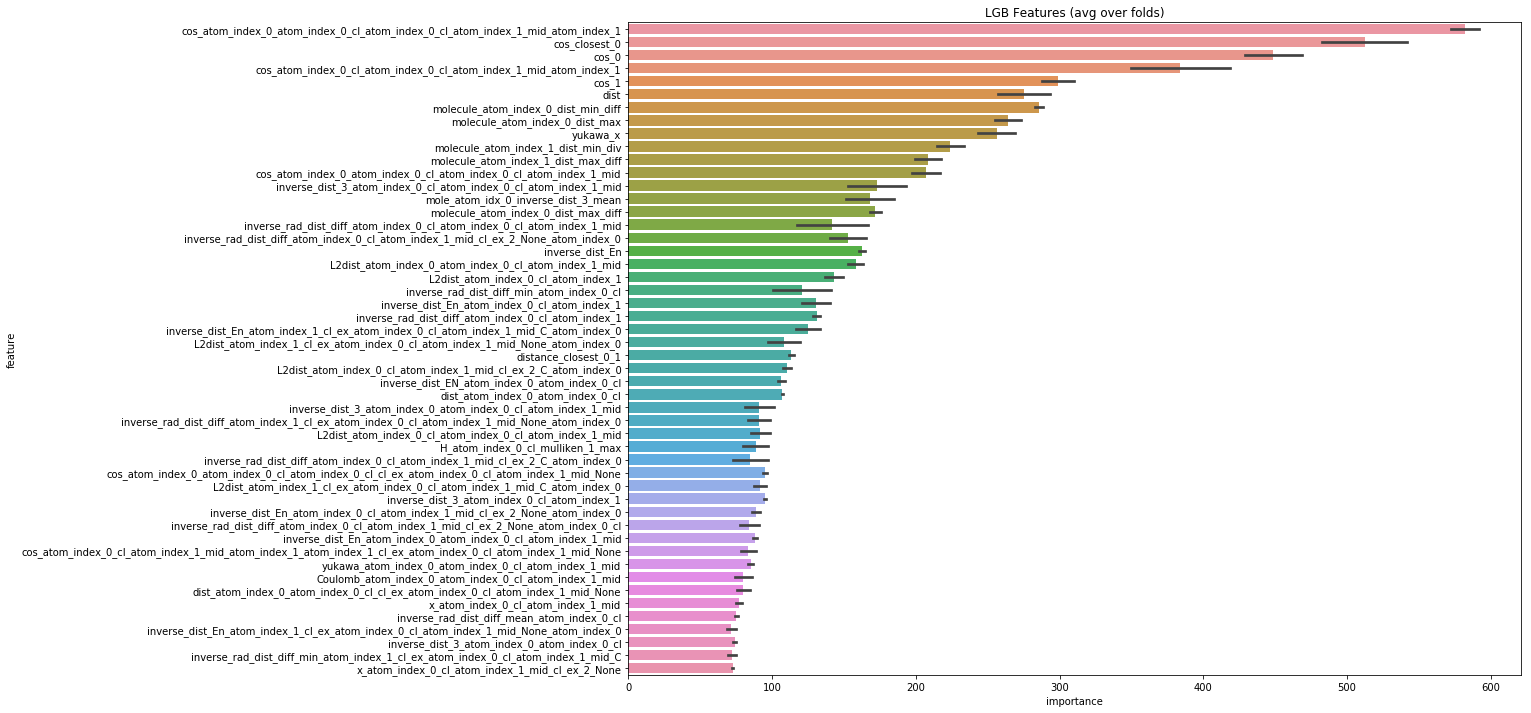

In [742]:
result_dict_lgb = train_model_regression(X = X_t, X_test = X_test_t, y = y_t, molecules = molecules_t,
                                        params = params, folds = kf, model_type = 'lgb', eval_metric = 'mae',
                                        plot_feature_importance = True, verbose = 500, early_stopping_rounds = 200,
                                        n_estimators = 400)

In [737]:
feature_importance = result_dict_lgb['feature_importance']
cols_useless = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[-350:]

In [738]:
cols_useless.head()

,importance
feature,
H_atom_index_0_cl_atom_index_1_mid_cl_ex_2_None_inverse_dist_3_sum,4.75
inverse_dist_EN_mean_atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C,4.75
C_atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C_yukawa_max,4.75
H_atom_index_0_cl_atom_index_1_mid_cl_ex_2_C_inverse_dist_3_sum,4.75
mulliken_atom_index_0_cl_cl_ex_atom_index_0_cl_atom_index_1_mid_C,4.75


In [ ]:
df_feature_3JHN, col_tokeep, scores = select_features(train_testing_3J, [], cols_tokeep, 12, 67, 35, 400)

In [745]:
df_feature_3JHN.to_csv('C:/Users/tyhe1/kaggle/Molecular_properties/good_feature/gf_3JHN_20190809.csv')